In [25]:
import copy
import socket
import os
import pickle 
# import ssm #need to/ keep 
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')

from scipy.ndimage import gaussian_filter1d
from get_data.read_neuro_beh_data import get_exp_features, load_json
from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
from beh_classification.behavior_features import get_behavior_features
from beh_classification.get_behavior_classifications import get_behavior_classification
# from beh_classification.beh_classification_utils import get_start_end_is_of_ones_in_binary_array
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors

from load_data_fncs import load_all_data, get_exp_dates
from analyse_rslds_utils import make_behavior_decoder, input_slds

In [26]:

from matplotlib.colors import LinearSegmentedColormap

#color palette for plotting, colors as in make_behavior_ethogram
palette = ["coral",     # forward
           "lightblue", # reverse
           "darkgreen", # turn
           "purple","red", "yellow", "black", "pink"]    # pause
cmap = LinearSegmentedColormap.from_list("behavior", palette, N=len(palette))


# Load data, model, behavior decoder

In [27]:


T = 1599
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()

velocity_og = np.array([full_beh_data[i]["velocity"][0:1599] for i in range(len(full_beh_data))])
acceleration_og = np.array([full_beh_data[i]["acceleration"][1:1600] for i in range(len(full_beh_data))])
head_curvature_og = np.array([full_beh_data[i]["head_angle"][0:1599] for i in range(len(full_beh_data))])
worm_curvature_og = np.array([full_beh_data[i]["worm_curvature"][0:1599] for i in range(len(full_beh_data))])
pumping_og = np.array([full_beh_data[i]["pumping"][0:1599] for i in range(len(full_beh_data))])
body_angle_mag_og = np.array([full_beh_data[i]["body_angle_mag"][0:1599] for i in range(len(full_beh_data))])
midlines_og =  np.array([full_beh_data[i]["midlines"][0:1599] for i in range(len(full_beh_data))])
body_angles_og =  np.array([full_beh_data[i]["body_angles"][0:1599] for i in range(len(full_beh_data))])

velocity = copy.deepcopy(velocity_og)
acceleration = copy.deepcopy(acceleration_og)
head_curvature = copy.deepcopy(head_curvature_og)
worm_curvature = copy.deepcopy(worm_curvature_og)
pumping = copy.deepcopy(pumping_og)
body_angle_mag =copy.deepcopy(body_angle_mag_og)
midlines =copy.deepcopy( midlines_og)
body_angles = copy.deepcopy(body_angles_og)


np.random.seed(0)

foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
items = np.array(os.listdir(foldername))
folders = np.array(["." not in directory for directory in items], dtype=bool)
folders = items[folders]

folder = folders[0]

with open(foldername+"/Y.npy", 'rb') as handle:  
    Y = pickle.load(handle)


with open(foldername+folder+"/saved_data/prior.npy", 'rb') as handle:
    global_worm = pickle.load(handle)
    global_worm.D = int(global_worm.D)

with open(foldername+folder+"/saved_data/prior_q.npy", 'rb') as handle:
    q = pickle.load(handle)
    

slds = global_worm

neural_labels = np.load(foldername+"/neurons.npy", allow_pickle=True)

# set up a single behavioral state array ("z" in the language of scott): 
z = [beh_classification["is_fwd"][0:1599]+ 2*beh_classification["is_rev"][0:1599]+ 4*beh_classification["is_pause"][0:1599]+3*beh_classification["is_turn"][0:1599]-1 for beh_classification in full_beh_classification]

# get estimated latents, states
q_x = q.mean_continuous_states
q_z = [slds.most_likely_states(q_x[w], Y[w]) for w in range(len(q_x))]

# traces, neural_labels, behavior_classification, mask = load_all_data_but_pretend_its_all_one_worm()

# velocity = np.array([full_beh_data[i]["velocity"][0:1599] for i in range(len(full_beh_data))])
# # velocity_all = 
# acceleration = np.array([full_beh_data[i]["acceleration"][1:1600] for i in range(len(full_beh_data))])
# head_curvature = np.array([full_beh_data[i]["head_angle"][0:1599] for i in range(len(full_beh_data))])
# worm_curvature = np.array([full_beh_data[i]["worm_curvature"][0:1599] for i in range(len(full_beh_data))])
# pumping = np.array([full_beh_data[i]["pumping"][0:1599] for i in range(len(full_beh_data))])

q_z_all = np.concatenate(q_z)
z_all = np.concatenate(z)

# Input rSLDS
input_list = ["AVA", "RIB", "RIM", "AIB"]
new_slds, input_dict = input_slds(slds,neural_labels, input_list, input_list)
new_slds.D = int(new_slds.D)
input_dict

beh_decoder = make_behavior_decoder(q_x, z)



Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


In [28]:

from rslds_visualization_utils import plot_states_and_neurons
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from compute_donut_utils import fix_signs, compute_phase,compute_radius, extract_rotation_angle, set_seed

import sys 

sys.path.append("/Users/friederikebuck/")
sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')
sys.path.append("/Users/friederikebuck/Downloads/worm notes/worm_code/fit_hierarchical/")

emissions_dim = max(traces.shape[1] for traces in full_traces)
model = slds

exp_dates = get_exp_dates() 




y = np.array(q_x)
pca = PCA(n_components=9, svd_solver="full")
pca.fit(np.concatenate(q_x[:-2])) #leave out two worms to test generalization
pca.components_ = fix_signs(pca.components_)
pca_x = pca.transform(np.concatenate(q_x))

#instead of training on phase, we'll train on sin and cosine to avoid the jumping between 2pi and 0
thetas = np.array([compute_phase(q_x[i], pca) for i in range(21)])
y_sin = [np.sin(y_i) for y_i in thetas]
y_cos = [np.cos(y_i) for y_i in thetas]

y = np.zeros((21, 1599, 3))
y[:,:,0] = y_sin
y[:,:,1] = y_cos
y[:,:,2] = [compute_radius(q_x[i], pca) for i in range(21)]

rotated_data = extract_rotation_angle(pca_x, n_neighbors=5)

rotated_data2d = rotated_data[:, 1:3]  # Project onto the principal plane
angles = np.arctan2(rotated_data2d[:, 1], rotated_data2d[:, 0])  

n_worms, timepoints = [21, 1599]
# angles = np.radians((270-np.degrees(angles+ np.pi))%360-180)

angles = angles.reshape(n_worms, timepoints)
rotated_data2d = rotated_data2d.reshape(n_worms, timepoints, 2)

y_sin = np.sin(angles)
y_cos = np.cos(angles)
radii = np.sqrt(rotated_data2d[..., 0]**2 + rotated_data2d[..., 1]**2)

y = np.stack([y_sin, y_cos, radii], axis=-1)
y.shape
z_norm = np.array(z, np.float64)

### This block is the main new thing compared to angles.ipynb

In [29]:
velocity -= velocity.mean()
velocity /= velocity.std()
acceleration -= acceleration.mean()
acceleration /= acceleration.std()
worm_curvature -= worm_curvature.mean()
worm_curvature /= worm_curvature.std()
z_norm -= z_norm.mean()
z_norm /= z_norm.std()
z_flat = np.array(z).flatten()
from angle.preprocess import prepare_data, split_and_normalize
from angle.train import train_model
from angle.plot_funcs_1 import plot_prediction, plot_held_out_worm

set_seed(42)
normalize=False
T = 5
X_all, y_all = prepare_data([velocity, acceleration, worm_curvature, z_norm], y, T=T, holdout_idxs=[20])
X_train, X_test, y_train, y_test, input_stats = split_and_normalize(X_all, y_all, normalize=normalize) # test here is held-out timepoints of held-in worms

input_dim = X_train.shape[2]
output_dim = y_train.shape[1]

in load data
[]
NOT using body angle mag for curvature
in replace_outliers_exp
in plot data
in reformar data
plotted
exp_acc1 (709200,)
exp_acc1.shape) (189120,)

resampled_pause (189120,)
in plot data


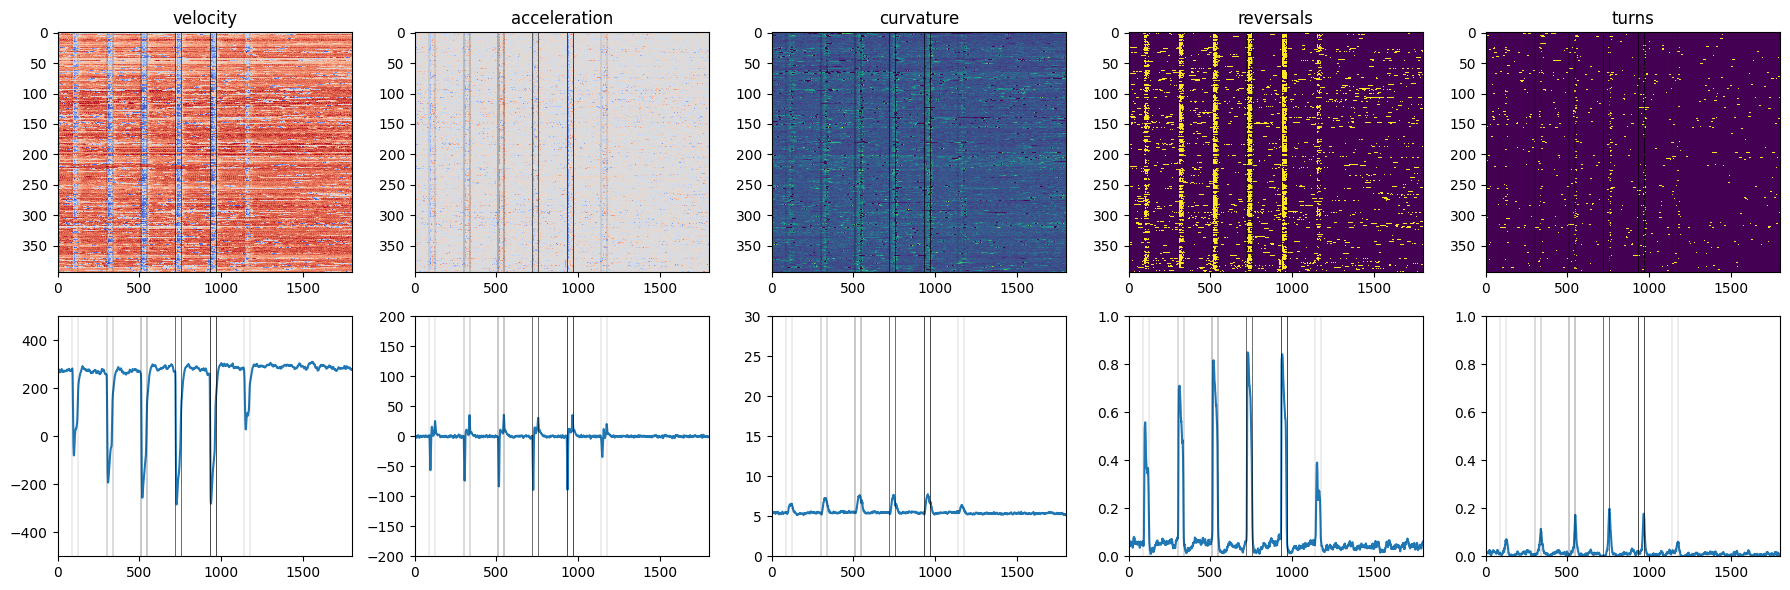

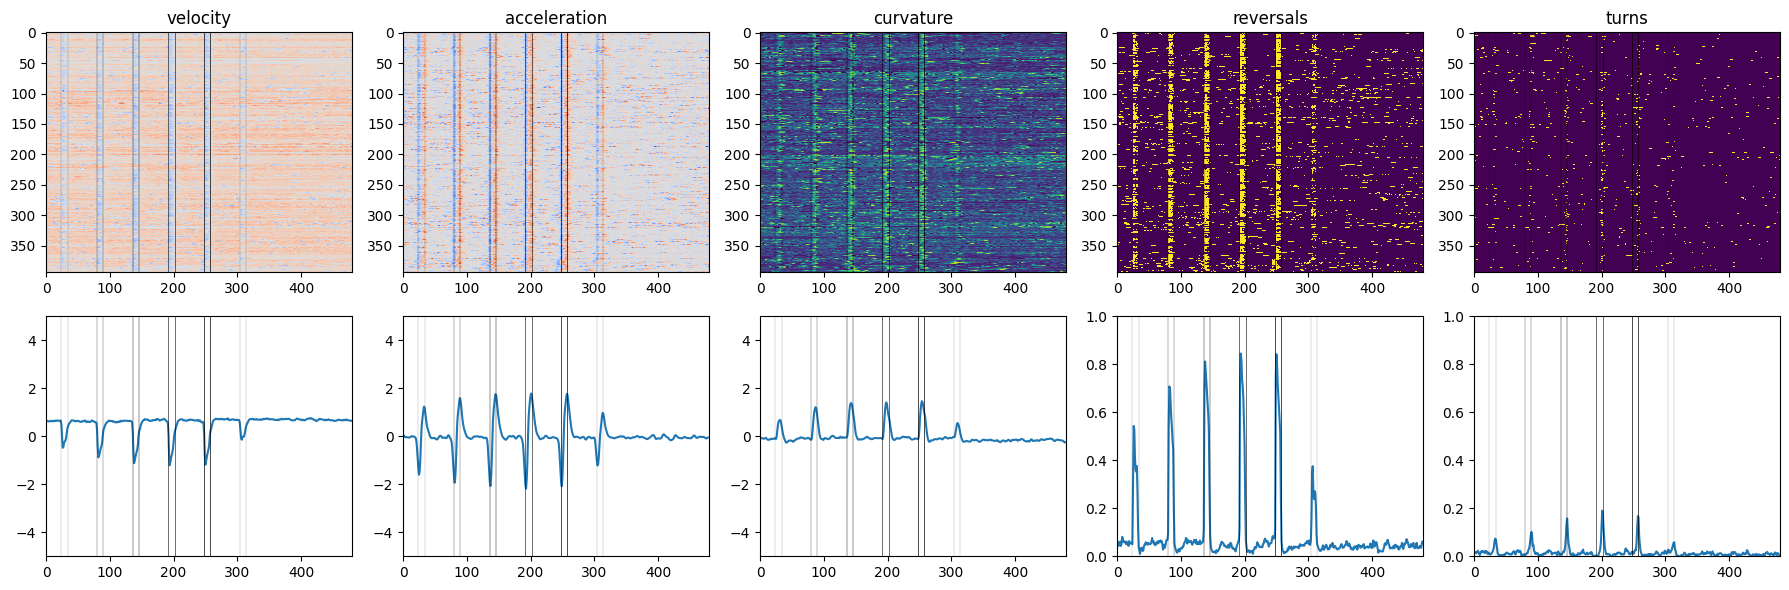

In [ ]:

import pickle 
pickle_fname = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/worm_angles_concat_neural.pickle"
with open(pickle_fname, "rb") as handle:
    worm_angles_concat_neural, worm_radii_concat_neural, model_neural_directed = pickle.load(handle) 
    



pickle_fname = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/worm_angles_concat_beh.pickle"
with open(pickle_fname, "rb") as handle:
   worm_angles, worm_radii, model_beh_directed =  pickle.load( handle) 
    
    
from load_and_process_FB_data_fncs_8 import load_data, reformat_data,plot_data,  analyze_data, replace_outliers_exp, reformat_data_1
# experiment = "duty_cycle"
# condition = "exp"
# neuron = "AVA"
# path = "/Users/friederikebuck/beh_analysis_results/csv/_Aim1_AVA_duty_cycle/"


# experiment = "duty_cycle"
# condition = "exp"
# neuron = "AIB"
# path = "/Users/friederikebuck/beh_analysis_results/csv/_AIBC-3_Aim1_AIB_duty_cycle/"


experiment = "duty_cycle"
condition = "exp"
neuron = "RIM"
path = "/Users/friederikebuck/beh_analysis_results/csv/_Aim1_RIM_duty_cycle/"


exp_data = load_data(experiment, condition, neuron, path = path)


exp_vel, exp_acc, exp_curve, exp_rev, exp_pause, exp_turn, exp_body_angle_mag  = replace_outliers_exp(exp_data, exp_data[0].shape)

exp_onsets = plot_data(exp_vel, exp_acc, exp_curve, exp_rev, exp_turn, experiment, fps=6)

resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn = reformat_data_1(exp_vel, 
                                                                                             exp_acc,
                                                                                             exp_curve,
                                                                                             exp_rev,
                                                                                             exp_turn, 
                                                                                             exp_pause,
                                                                                             z_flat,
                                                                                             velocity, 
                                                                                             acceleration, 
                                                                                             worm_curvature,
                                                                                            #  X_all,  
                                                                                             plot=False, 
                                                                                             sep_pos_neg_resample = True)

onsets = plot_data(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, experiment, fps=1.6, orig = False)
resampled_onsets = onsets

###using body angle mag;
pickle_fname = f"/Users/friederikebuck/Downloads/worm notes/processed_checkpts/aim1_FB_beh_{neuron}_{condition}_{experiment}_phase_features_exp.pickle"
with open(pickle_fname, "rb") as handle:
    resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn,behaviors_all,  inferred_phases_all, inferred_rad_all = pickle.load(handle) 
    

# Plot all worms -- LSTM

In [1]:
from predict_latency_prob_from_features_donut import fit_eval_linearSVC, plot_coeffs, prep_FB_inputs_select_features_only_no_onset, visualize_model_classification ##Real ** 
from predict_latency_prob_from_features_donut import fit_eval_lasso

ImportError: cannot import name 'fit_eval_lasso' from 'predict_latency_prob_from_features_donut' (/Users/friederikebuck/Downloads/worm notes/worm_code/predict_latency_prob_from_features_donut.py)

In [ ]:


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
import warnings
from predict_latency_prob_from_features_donut import prep_FB_inputs, fit_visualize_model_classifiction, prep_FB_inputs_features_only, latency_to_reversal
from predict_latency_prob_from_features_donut import prep_FB_inputs_select_features_only, prep_FB_inputs_features_only, feature_all_to_resampled, resample_2d
# # from predict_latency_prob_from_features_donut_6 import visualize_model_classification, combine_FB_features_across_stim, prep_FB_inputs_select_features_only, latency_to_reversal, fit_visualize_model_regression
from predict_latency_prob_from_features_donut import prep_FB_inputs_select_features_only, prep_FB_inputs_features_only
from predict_latency_prob_from_features_donut import visualize_model_classification, combine_FB_features_across_stim
from predict_latency_prob_from_features_donut import prep_FB_inputs_feature_and_donut, prep_FB_inputs_features_only
# from predict_latency_prob_from_features_donut import visualize_model_classification, combine_FB_features_across_stim


from predict_latency_prob_from_features_donut import prep_FB_inputs_select_features_only, prep_FB_inputs_features_only, feature_all_to_resampled







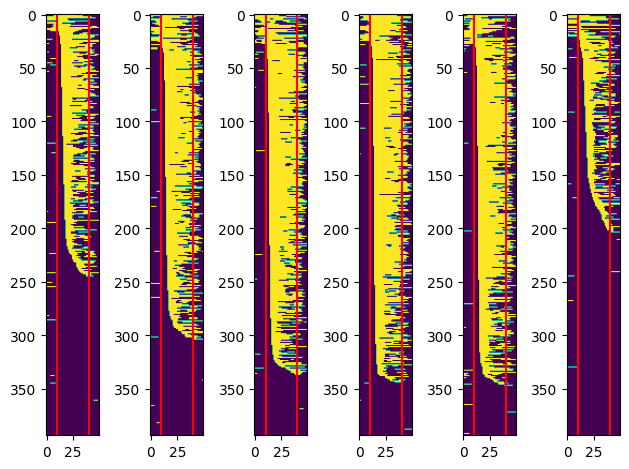

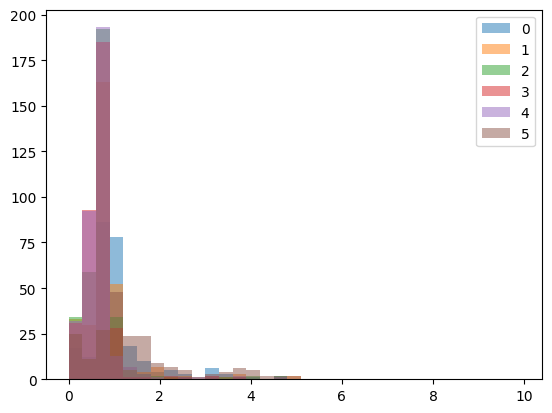

In [32]:
if experiment == "time_titration":
    durations = [1,3,5,10]
else:
    durations = [5,5,5,5,5,5]
    if experiment == "hiscl":
        durations = [5,5]

exp_offsets = np.array([exp_onsets[i] + 6*durations[i] for i in range(len(durations))])


fig,ax = plt.subplots(1,len(durations))
fig2,ax2 = plt.subplots()

latencies = []
for i in range(len(durations)):
    latency = latency_to_reversal(exp_rev, exp_onsets[i], max_latency = 6*durations[i]+1)
    idx = np.argsort(latency)
    ax[i].imshow(exp_rev[idx, -10+exp_onsets[i]:exp_offsets[i]+10], aspect="auto")
    ax[i].axvline(10, c='r')
    ax[i].axvline(10+6*durations[i], c='r')
    ax2.hist(latency/6, bins = np.arange(0,10,.3), alpha = 0.5, label=i)
    # latency[np.isnan(latency)] = np.nanmax(latency)+1
    latencies.append(latency)
fig.tight_layout()
latencies = np.array(latencies)/6
ax2.legend()

In [33]:
# ###############
# ###############checkk get donut stim works** 
# ###get inputs into lstm 
# ###############
beh_map = [z_norm.min(), z_norm.min()/2 + z_norm.max()/2, z_norm.max()]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import copy
import pickle
import matplotlib.cm as cm

import warnings
    
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import copy
import pickle

import pandas as pd 

from plot_donut_vs_phase import create_X_sequences
from predict_latency_prob_from_features_donut import prep_FB_inputs_select_features_only_no_onset 


def feature_all_to_resampled(inferred_phases_all, n_tracks):
   
    inferred_phases_all = inferred_phases_all.reshape(n_tracks, -1)
   
    n_timesteps = inferred_phases_all.shape[1]
    print("n_timesteps", n_timesteps)
    # inferred_phases_all_shifted = np.zeros((n_tracks,n_timesteps+5+8))+np.nan #ask Bennet about the 8 extra time steps missing
    # inferred_phases_all_shifted[:, 5:-8] = inferred_phases_all
    
    inferred_phases_all_shifted = np.zeros((n_tracks,n_timesteps+5+8+8))+np.nan #ask Bennet about the 8 extra time steps missing
    inferred_phases_all_shifted[:, 5:-16] = inferred_phases_all
    return inferred_phases_all_shifted

def flatten_and_remove_nans(resampled_features):
    return resampled_features.flatten()

def prep_FB_inputs(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, z,   T = 5
                #    times, beh_map, 
                #    lag=16, inclusion_thresh =3, 
                #    remove_revs=False, 
                  
                   ): 

    behavior_input = np.array(resampled_rev+2*resampled_turn, dtype=np.float64)
    behavior_input -= np.array(z).mean()
    behavior_input /= np.array(z).std()

    X_all_LSTM = []
    for new_worm_idx in range(len(resampled_vel)):
       
        X_new_worm = np.stack([resampled_vel[new_worm_idx], resampled_acc[new_worm_idx], resampled_curve[new_worm_idx], behavior_input[new_worm_idx]], axis=1)  
        # X_new_worm = np.stack([resampled_vel[new_worm_idx], resampled_acc[new_worm_idx], behavior_input[new_worm_idx]], axis=1)  
        X_new_tensor = torch.tensor(X_new_worm, dtype=torch.float32)
        
        if T > 0:
            X_new_seq1 = create_X_sequences(X_new_tensor, T).numpy() #torch.Size([475, 5, 4]), = n_frames, time delay, 4 is the feature  #
        else: 
            X_new_seq1 = X_new_tensor.numpy()
        
        n_frames, delay, n_features = X_new_seq1.shape
        X_new_seq1 = X_new_seq1.reshape((n_frames,  delay*n_features)) # check how this is shaped it will be f1_t-T, f2_t-T, f3_t-T, f4_t-T, ; f1_t-T+1, f2_T+1, f3_T+1 f4_T+1
        
            
        X_all_LSTM.append(X_new_seq1)
    # X_all_LSTM = np.concatenate(X_all_LSTM, axis = 1 ) # i guess should check if reshape how it reshapes.. ie if feautres are all together or not 
    X_all_LSTM = np.array(X_all_LSTM)#shape (n_tracks, n_frames, n_features)
    # feature_names = np.array([[f"vel_t-{T - t - 1}", f"accel_t-{T - t - 1}",
    #                                f"curv_t-{T - t - 1}", f"beh_t-{T - t - 1}"]
    #                               for t in range(T)]).flatten()

    return X_all_LSTM


    
    
# def plot_coeffs(model, feature_names, model_label,  n_time_steps, feature_names_ordered = None, xlim = None, coeffs = None):
#     if coeffs is None: 
            
#         try: 
            
#             coeffs = model.coef_
#         except: 
#             # print(model.coef_.shape)
#             coeffs = model.coef_[0]
#             # coeffs = pd.Series(model.coef_[0], index=feature_names)
            
#         if feature_names_ordered : 
#             coeffs = coeffs.reshape(n_time_steps,-1 ).reshape((len(feature_names), -1), order='F').flatten()
#             feature_names = feature_names.reshape( n_time_steps, -1).reshape((len(feature_names), -1), order='F').flatten()
#     # if coeffs is None: 
#     try: 
#         coeffs = pd.Series(model.coef_, index=feature_names)
#     except:
#         coeffs = pd.Series(model.coef_[0], index=feature_names)
#         # sort_indices = np.argsort(np.argsort(feature_names_ordered)[np.argsort(feature_names)])
#         # coeffs = coeffs[sort_indices]
#         # feature_names = feature_names[sort_indices]

#     # Filter non-zero coefficients and sort
#     # nonzero_coeffs = coeffs[coeffs != 0].sort_values()
#     nonzero_coeffs = coeffs

#     # Plot
#     fig_height = max(2, 0.3 * len(nonzero_coeffs))
#     fig, ax = plt.subplots(figsize=(8, fig_height))

#     # Plot on ax
#     nonzero_coeffs.plot(kind='barh', ax=ax)

#     # Labels and formatting
#     ax.set_xlabel("Coefficient Value")
#     if xlim is not None: 
        
#         ax.set_xlim(xlim)
#     ax.set_title(f"{model_label} coefficients")
#     ax.grid(True, axis='x')

#     fig.tight_layout()
#     return fig, ax 
#     # plt.show()
    
def fit_visualize_model_classifiction(model, model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, get_coeffs = True,  feature_names_ordered = None,  xlim = None, coeffs = None):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # model_label = f"{i}; logistic"
    print(f"{model_label}Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{model_label}Precision:", precision_score(y_test, y_pred, average='weighted'))
    print(f"{model_label}Recall:", recall_score(y_test, y_pred, average='weighted'))
    print(f"{model_label}F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    disp = ConfusionMatrixDisplay.from_estimator(model, X_train,  y_train, cmap='Blues')
    disp.ax_.set_title(f"{model_label}train")
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test,  y_test, cmap='Blues')
    disp.ax_.set_title(f"{model_label}test")
    if get_coeffs:
        fig, ax = plot_coeffs(model, feature_names, model_label, n_time_steps, feature_names_ordered = feature_names_ordered, xlim = xlim, coeffs = coeffs)
        ax.set_title(f"{model_label}")
    return model, y_pred

def fit_visualize_model_regression(model, model_label, feature_names, X_train, X_test, y_train, y_test,n_time_steps, feature_names_ordered = None, coeffs = None, get_coeffs = True):
    # model_real = copy.deepcopy(model)
    # model_real.fit(X_train, y_train)
    # print(f"{model_label} Linear Regression R²:", model.score(X_test, y_test))
    # # print("Coefficients:", model.coef_)
    # # model_label= f"{i};lin"
    # plot_results(model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, feature_names_ordered = feature_names_ordered)
    fit_visualize_model_regression_vs_shuffle(model, model_label, feature_names, X_train, X_test, y_train, y_test,n_time_steps, feature_names_ordered = feature_names_ordered, coeffs = coeffs, get_coeffs = get_coeffs)


def latency_to_reversal(reshaped_rev, start_time, max_latency=None):
    n_worms, T = reshaped_rev.shape
    latencies = np.full(n_worms, np.nan)

    for i in range(n_worms):
        end_time = T if max_latency is None else min(T, start_time + max_latency)
        future = reshaped_rev[i, start_time:end_time]
        reversal_indices = np.where(future)[0]
        if reversal_indices.size > 0:
            latencies[i] = reversal_indices[0]
    
    return latencies

    
def fit_visualize_model_regression_vs_shuffle(model, model_label, feature_names, X_train, X_test, y_train, y_test,n_time_steps, feature_names_ordered = None, coeffs = None, get_coeffs = True):
    model_real = copy.deepcopy(model)
    model_real.fit(X_train, y_train)
    # print(f"{model_label} Linear Regression R²:", model_real.score(X_test, y_test))
    # plot_results(model_real, model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, feature_names_ordered = feature_names_ordered, compare_to_suffle = compare_to_suffle  )
    # print("Coefficients:", model.coef_)
    # model_label= f"{i};lin"
    model_shuffle = copy.deepcopy(model)
    model_shuffle.fit(X_train, np.random.permutation(y_train))
    # plot_results(model_shuffle, model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, feature_names_ordered = feature_names_ordered, compare_to_suffle = compare_to_suffle  )
    
    
    y_pred_real = model_real.predict(X_test)
    fig, axs = plt.subplots(1,2)
    ax = axs[0]
    ax.scatter(y_test, y_pred_real, alpha=0.7)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel("Test Actual Latency")
    ax.set_ylabel("Test Predicted Latency")
    ax.set_title( f"{model_label}; R²:{np.round(model_real.score(X_test, y_test),2)}")
    
    y_pred_shuffled = model_shuffle.predict(X_test)
    ax = axs[1]
    ax.scatter(y_test, y_pred_shuffled, alpha=0.7)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel("Test Actual Latency")
    ax.set_ylabel("Test Predicted Latency")
    ax.set_title( f"{model_label}; shuffled; R²:{np.round(model_shuffle.score(X_test, y_test),2)}")
    # plt.tight_layout()
    y_pred_real = model_real.predict(X_train)
    fig, axs = plt.subplots(1,2)
    ax = axs[0]
    ax.scatter(y_train, y_pred_real, alpha=0.7)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax.set_xlabel("Train Actual Latency")
    ax.set_ylabel("Train Predicted Latency")
    ax.set_title( f"{model_label}; R²:{np.round(model_real.score(X_train, y_train),2)}")
    
    y_pred_shuffled = model_shuffle.predict(X_train)
    ax = axs[1]
    ax.scatter(y_train, y_pred_shuffled, alpha=0.7)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax.set_xlabel("Train Actual Latency")
    ax.set_ylabel("Train Predicted Latency")
    ax.set_title( f"{model_label}; shuffled; R²:{np.round(model_shuffle.score(X_train, y_train),2)}")
    # plt.tight_layout()
    
    if get_coeffs: 
        plot_coeffs(model_real, feature_names,model_label,n_time_steps,   feature_names_ordered = feature_names_ordered, coeffs = coeffs)


############
##############

def prep_FB_inputs_donut_only( inferred_phases_all, inferred_rad_all, resampled_onset, n_tracks):
    phase_resampled = feature_all_to_resampled(inferred_phases_all, n_tracks)
    radii_resampled = feature_all_to_resampled(inferred_rad_all, n_tracks) 
    
    X_donut_stim = np.concatenate([phase_resampled[:, resampled_onset, None] ,  radii_resampled[:, resampled_onset, None] ], axis = 1)
    # X_donut_stim = X_donut[:, resampled_onset,:]
    
    feature_names = ["phase", "radius"]
    return X_donut_stim, feature_names

    
def prep_FB_inputs_feature_and_donut(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, inferred_phases_all, inferred_rad_all,resampled_onset, n_tracks,   n_timesteps, z,lstm_lag = 0, include_beh = False):
    # print("n_timesteps", n_timesteps)
    X_stim_features, feature_names = prep_FB_inputs_features_only(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, resampled_onset,   n_timesteps,z, lstm_lag = lstm_lag, include_beh = include_beh)#shape (n_tracks, n_frames, n_features)

    X_donut_stim, donut_names = prep_FB_inputs_donut_only( inferred_phases_all, inferred_rad_all, resampled_onset, n_tracks)

    X_stim_all =  np.concatenate([X_stim_features ,  X_donut_stim], axis = 1)
    feature_names_all = np.array(feature_names.tolist()+donut_names)
    return X_stim_all, feature_names_all


    
# def visualize_model_classification(model, model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, get_coeff = True,  feature_names_ordered = None,  xlim = None, coeffs = None):
    
#     # model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"{model_label}Accuracy:", accuracy_score(y_test, y_pred))
#     print(f"{model_label}Precision:", precision_score(y_test, y_pred, average='weighted'))
#     print(f"{model_label}Recall:", recall_score(y_test, y_pred, average='weighted'))
#     print(f"{model_label}F1 Score:", f1_score(y_test, y_pred, average='weighted'))
#     # disp = ConfusionMatrixDisplay.from_estimator(model, X_train,  y_train, cmap='Blues')
#     # disp.ax_.set_title(f"{model_label}train")
#     disp = ConfusionMatrixDisplay.from_estimator(model, X_test,  y_test, cmap='Blues')
#     disp.ax_.set_title(f"{model_label}test")
#     if get_coeff:
#         fig, ax = plot_coeffs(model, feature_names, model_label, n_time_steps, feature_names_ordered = feature_names_ordered, xlim = xlim, coeffs = coeffs)
#         ax.set_title(f"{model_label}")
#     return model, y_pred

def resample_fps(feature_arr, target_fps,  original_fps):
    # Resample using linear interpolation
    indices = np.arange(len(feature_arr))
    new_indices = np.linspace(0, len(feature_arr) - 1, int(len(feature_arr) * (target_fps / original_fps)))
    resampled_values = np.interp(new_indices, indices, feature_arr)
    return resampled_values

def resample_2d(inferred_phases_all_shifted, target_fps,  original_fps):
    n_tracks = inferred_phases_all_shifted.shape[0]
    resampled_tracks = []
    for track_i in range(n_tracks):
        resampled = resample_fps(inferred_phases_all_shifted[track_i, :], target_fps,  original_fps)
        resampled_tracks.append(resampled[None,:])

    inferred_phases_all_shifted_high_fps = np.concatenate(resampled_tracks, axis= 0 )
    return inferred_phases_all_shifted_high_fps



def plot_results_prediction(model, model_label, feature_names, X_train, X_test, y_train, y_test, n_time_steps, feature_names_ordered = None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, alpha=0.7)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel("Test Actual Latency (s) ")
    ax.set_ylabel("Test Predicted Latency (s) ")
    ax.set_title( f"{model_label}; R²:{model.score(X_test, y_test)}")
    ax.set_ylim([0,6])
    ax.set_xlim([0,6])
    
    
    
    y_pred = model.predict(X_train)
    fig, ax = plt.subplots()
    ax.scatter(y_train, y_pred, alpha=0.7)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax.set_xlabel("Train Actual Latency (s) ")
    ax.set_ylabel("Train Predicted Latency (s) ")
    ax.set_title( f"{model_label}; R²:{model.score(X_train, y_train)}")
    ax.set_ylim([0,6])
    ax.set_xlim([0,6])
    
    plot_coeffs(model, feature_names,model_label,n_time_steps,   feature_names_ordered = feature_names_ordered)
  
# def prep_FB_inputs_select_features_only_no_onset(
#                     features_list, feature_labels, 
#                      n_timesteps,
#                     fps = None
#                    ): 
#     if fps is None: 
#         fps = 1

#     X_all_LSTM = []
#     for new_worm_idx in range(len(features_list[0])):
#         X_new_worm = np.stack([feature[new_worm_idx] for feature in features_list
#                                 ], axis=1)  
#         feature_names = np.array([[f"{lbl}_t-{(n_timesteps - t - 1)/fps}" for lbl in feature_labels] for t in range(n_timesteps)]).flatten()
#         X_new_tensor = torch.tensor(X_new_worm, dtype=torch.float32)
        
#         if n_timesteps> 0:
#             X_new_seq1 = create_X_sequences(X_new_tensor, n_timesteps).numpy() #torch.Size([475, 5, 4]), = n_frames, time delay, 4 is the feature  #
#         else: 
#             X_new_seq1 = X_new_tensor.numpy()
        
#         n_frames, delay, n_features = X_new_seq1.shape
#         X_new_seq1 = X_new_seq1.reshape((n_frames,  delay*n_features)) # check how this is shaped it will be f1_t-T, f2_t-T, f3_t-T, f4_t-T, ; f1_t-T+1, f2_T+1, f3_T+1 f4_T+1

        
#         X_all_LSTM.append(X_new_seq1)
#     X_all_LSTM = np.array(X_all_LSTM)

#     # if stim_onset is None: 
#     #     stim_onset = resampled_onset #- lstm_lag
#     # X_stim_features = X_all_LSTM[:, stim_onset, :]
#     return X_all_LSTM, feature_names

    # return X_stim_features, feature_names
  
def prep_FB_inputs_select_features_only(
                    features_list, feature_labels, 
                    resampled_onset,  n_timesteps,
                    z, 
                    lstm_lag = 0,
                    stim_onset = None, fps = None
                   ): 
    # if fps is None: 
    #     fps = 1

    # X_all_LSTM = []
    # for new_worm_idx in range(len(features_list[0])):
    #     X_new_worm = np.stack([feature[new_worm_idx] for feature in features_list
    #                             ], axis=1)  
    #     feature_names = np.array([[f"{lbl}_t-{(n_timesteps - t - 1)/fps}" for lbl in feature_labels] for t in range(n_timesteps)]).flatten()
    #     X_new_tensor = torch.tensor(X_new_worm, dtype=torch.float32)
        
    #     if n_timesteps> 0:
    #         X_new_seq1 = create_X_sequences(X_new_tensor, n_timesteps).numpy() #torch.Size([475, 5, 4]), = n_frames, time delay, 4 is the feature  #
    #     else: 
    #         X_new_seq1 = X_new_tensor.numpy()
        
    #     n_frames, delay, n_features = X_new_seq1.shape
    #     X_new_seq1 = X_new_seq1.reshape((n_frames,  delay*n_features)) # check how this is shaped it will be f1_t-T, f2_t-T, f3_t-T, f4_t-T, ; f1_t-T+1, f2_T+1, f3_T+1 f4_T+1

        
    #     X_all_LSTM.append(X_new_seq1)
    # X_all_LSTM = np.array(X_all_LSTM)
    X_all_LSTM, feature_names = prep_FB_inputs_select_features_only_no_onset(
                    features_list, feature_labels, 
                     n_timesteps,
                    fps = fps
                   )

    if stim_onset is None: 
        stim_onset = resampled_onset #- lstm_lag
    X_stim_features = X_all_LSTM[:, stim_onset, :]

    return X_stim_features, feature_names

def prep_FB_inputs_features_only(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, resampled_onset,  n_timesteps, z,
                                 lstm_lag = 0,
                                 stim_onset = None, 
                                 include_beh = False, 
                                 fps = None
                   ): 

    behavior_input = np.array(resampled_rev+2*resampled_turn, dtype=np.float64)
    behavior_input -= np.array(z).mean()
    behavior_input /= np.array(z).std()
    if fps is None: 
        fps = 1

    X_all_LSTM = []
    for new_worm_idx in range(len(resampled_vel)):
        if include_beh:
            X_new_worm = np.stack([resampled_vel[new_worm_idx], resampled_acc[new_worm_idx], resampled_curve[new_worm_idx], behavior_input[new_worm_idx]], axis=1)  

            feature_names = np.array([[f"vel_t-{np.round((n_timesteps - t - 1)/fps, 2)}", f"accel_t-{np.round((n_timesteps - t - 1)/fps, 2)}",
                                f"curv_t-{np.round((n_timesteps - t - 1)/fps, 2)}", f"beh_t-{np.round((n_timesteps - t - 1)/fps, 2)}"]
                                for t in range(n_timesteps)]).flatten()
        else: 
            X_new_worm = np.stack([resampled_vel[new_worm_idx], resampled_acc[new_worm_idx], resampled_curve[new_worm_idx], 
                                   
                                #    behavior_input[new_worm_idx]
                                   
                                   ], axis=1)  
            feature_names = np.array([[f"vel_t-{np.round((n_timesteps - t - 1)/fps, 2)}", f"accel_t-{np.round((n_timesteps - t - 1)/fps, 2)}",
                                f"curv_t-{np.round((n_timesteps - t - 1)/fps, 2)}"]
                                for t in range(n_timesteps)]).flatten()
        # X_new_worm = np.stack([resampled_vel[new_worm_idx], resampled_acc[new_worm_idx], behavior_input[new_worm_idx]], axis=1)  
        X_new_tensor = torch.tensor(X_new_worm, dtype=torch.float32)
        
        if n_timesteps> 0:
            X_new_seq1 = create_X_sequences(X_new_tensor, n_timesteps).numpy() #torch.Size([475, 5, 4]), = n_frames, time delay, 4 is the feature  #
        else: 
            X_new_seq1 = X_new_tensor.numpy()
        
        n_frames, delay, n_features = X_new_seq1.shape
        X_new_seq1 = X_new_seq1.reshape((n_frames,  delay*n_features)) # check how this is shaped it will be f1_t-T, f2_t-T, f3_t-T, f4_t-T, ; f1_t-T+1, f2_T+1, f3_T+1 f4_T+1

        
        X_all_LSTM.append(X_new_seq1)
    # X_all_LSTM = np.concatenate(X_all_LSTM, axis = 1 ) # i guess should check if reshape how it reshapes.. ie if feautres are all together or not 
    X_all_LSTM = np.array(X_all_LSTM)#shape (n_tracks, n_frames, n_features)

    if stim_onset is None: 
        stim_onset = resampled_onset #- lstm_lag
    X_stim_features = X_all_LSTM[:, stim_onset, :]
    # X_stim_features = X_all_LSTM[:, resampled_onset - lstm_lag, :]

    return X_stim_features, feature_names


def combine_FB_features_across_stim(
    stim_i_to_features,stim_i_to_Ys,  feature_names, 
  
                   ): 
    feature_names_all = np.array(feature_names.tolist()+[f"stim_{stim_i}" for stim_i in stim_i_to_features.keys()])
    
    all_stim_X_stim_features  = []
    all_stim_Y = []
    n_stim = len(stim_i_to_features.keys())
    for i, (stim_i, X_stim_features) in enumerate(stim_i_to_features.items()):
        n_frames, n_features = X_stim_features.shape
        stim_bin_features = np.zeros((n_frames,n_stim ))
        stim_bin_features[:, i] = 1
        all_stim_X_stim_features.append(np.concatenate([X_stim_features, stim_bin_features], axis =1))
        all_stim_Y.append(stim_i_to_Ys[stim_i])
    all_stim_X_stim_features = np.concatenate(all_stim_X_stim_features, axis =0)
    all_stim_Y = np.concatenate(all_stim_Y, axis = 0 )
        
    
    return all_stim_X_stim_features, all_stim_Y, feature_names_all


In [ ]:

def prep_data_latency(X_stim_all, Y_latency):
    valid_indices = np.argwhere((~np.isnan(Y_latency)) & (Y_latency != 0)).flatten() 
    # print("in pre data latency")
    # print("valid_indices", valid_indices)
    # print("valid_indices", valid_indices.shape)
    # print("X_stim_all.shape", X_stim_all.shape)
    
    X_stim_all_latency = X_stim_all[valid_indices]
    # print("X_stim_all_latency.shape", X_stim_all_latency.shape)
    Y_latency_valid = Y_latency[valid_indices]
    return  X_stim_all_latency, Y_latency_valid


def prep_data_rev_prob(X_stim_all, Y_latency):
    no_rev_at_onset = Y_latency!=0
    Y_prob = np.logical_not(np.isnan(Y_latency[no_rev_at_onset]))# classfy y/n did rev happen
    X_prob = copy.deepcopy(X_stim_all[no_rev_at_onset])
    return X_prob, Y_prob

# def fit_eval_lasso(X_train, X_test, y_train, y_test):
#     alphas = np.logspace(-4, 2, 20)
#     lasso = Lasso(max_iter=10000)
#     grid_search = GridSearchCV(lasso, {'alpha': alphas}, cv=5, scoring='r2')
#     grid_search.fit(X_train, y_train)

#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_test)
#     score = r2_score(y_test, y_pred)
#     return best_model, y_pred, score

# def fit_eval_linearSVC(X_train, X_test, y_train, y_test):
    
#     param_grid = {
#         'C': [0.001, 0.01, 0.1, 1, 10, 100]
#     }

#     model = LinearSVC(penalty='l1', dual=False, max_iter=10000)
#     # Grid search
#     grid = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
#     grid.fit(X_train, y_train)
#     c = grid.best_params_['C']
#     best_model = grid.best_estimator_
    
#     y_pred = best_model.predict(X_test)
#     score = balanced_accuracy_score(y_test, y_pred)  


#     return best_model, y_pred, score

def train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                           
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               score_label = "",
                               single_feature = False, 
                               rev_bin = None, 
                               all_timesteps = None, 
                               check_warnings = True
                            ):
    if check_warnings:
        with warnings.catch_warnings():
            fig, ax = plt.subplots()
            best_models = {} 
            all_scores_per_i = {}
            results_dict = {}
            for i, (data_onset, exp_onset) in enumerate(zip(data_onsets, exp_onsets)):
                
                onset = data_onset-1
                score_means = []
                score_stds = []
                n_timesteps_list = []
                Y_latency = latency_to_reversal(exp_rev, exp_onset, max_latency = 6*durations[i]+1)/6 # nan where not 
                if rev_bin is not None: 
                    fig3, ax3 = plt.subplots(figsize = (8,20))
                    vline = onset - lstm_lag
                    sort = np.argsort(Y_latency)
                    ax3.imshow(rev_bin[sort, vline-25:vline+25])
                    
                    ax3.set_title(f"onset: {onset}")
                    ax3.axvline(25, color = "red")
                    
                
                if all_timesteps is None: 
                    all_timesteps = range(1, 15, 3)

                for n_timesteps in all_timesteps:
                    print("i, n_timesteps",i,  n_timesteps)
                    scores = []
                    models = []

                

                    X_stim_all, feature_names_all = prep_FB_inputs_select_features_only(
                        feature_list, feature_labels, onset,  n_timesteps, z, lstm_lag = lstm_lag, fps = fps
                                    )
                    


                    
                    X,Y = data_prep_fnc(X_stim_all, Y_latency)



                    for split_idx in range(n_splits):
                        X_train, X_test, y_train, y_test = train_test_split(
                            X, Y, test_size=test_size, random_state=split_idx)
                        best_model, y_pred, score = model_fit_fnc(X_train, X_test, y_train, y_test)
                        scores.append(score)
                        models.append((best_model,X_train, X_test, y_train, y_test))

                    scores_mean = np.mean(scores)
                    scores_std = np.std(scores)
                    best_model_idx = np.argmax(scores)
                    best_model_overall = models[best_model_idx]

                    # Save results
                    n_timesteps_list.append(n_timesteps)
                    # all_r2_means.append(r2s)
                    all_scores_per_i[(i, n_timesteps)] = scores
                    score_means.append(scores_mean)
                    score_stds.append(scores_std)
                    results_dict[(i, n_timesteps)] = (scores_mean, scores_std)
                    best_models[(i, n_timesteps)] = best_model_overall
                    

                # cmap1 = cm.get_cmap('tab10', len(resampled_onsets))
                ax.errorbar(np.array(n_timesteps_list)/fps, score_means, yerr=score_stds, #color=cmap1(i),
                            fmt='-o', capsize=5, label = f"stim {i}")

                ax.set_title(title_label)
                ax.set_xlabel("max time delay (sec)")
                ax.set_ylabel(f"{score_label}")
                ax.legend()
                plt.grid(True)
                plt.tight_layout()


            n_timesteps = all_timesteps[-2]
            for i in range(len(exp_onsets)):
                model,X_train, X_test, y_train, y_test = best_models[(i, n_timesteps)] 

                model_label= f"{title_label}; stim{i}"#; lasso_a{np.round(alpha,2)}"
                if single_feature: 
                    feature_lbl = feature_labels[0]
                    feature_names = np.array([[f"{feature_lbl}_t-{np.round((n_timesteps - t - 1)/fps, 2)}"]
                                        for t in range(n_timesteps)]).flatten()
                    result_visualization_fnc(model, model_label, feature_names, X_train, X_test, y_train, y_test, n_timesteps,  feature_names_ordered = False, coeffs = model.coef_[0])#, xlim = [-2,1])
                    
                else: 
                    _,  feature_names_all = prep_FB_inputs_select_features_only(
                        # resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn,
                        feature_list, feature_labels, onset,  n_timesteps, z, lstm_lag = lstm_lag,  fps = fps
                                    )
                    print("feature_names_all",feature_names_all)
                    result_visualization_fnc(model, model_label, feature_names_all, X_train, X_test, y_train, y_test, n_timesteps,  feature_names_ordered = False)#, xlim = [-2,1])
    
def train_model_single_feature(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                           
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               rev_bin = None, 
                               score_label = "",
                               all_timesteps= None, 
                               check_warnings = True
                               ):
    
    
    for feature, feature_lbl in zip(feature_list, feature_labels
                                                    ):
        
        single_feature_list = [feature]
        single_feature_labels = [feature_lbl]
        train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               single_feature_list, 
                               single_feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                           
                               title_label,
                               test_size =test_size, 
                               n_splits = n_splits, 
                               score_label = score_label,
                               lstm_lag = lstm_lag, 
                               single_feature = True, 
                               rev_bin = rev_bin, 
                               all_timesteps  = all_timesteps, 
                               check_warnings = check_warnings
                            )
        

    plt.show()


In [ ]:
def get_plot_multi_stim_model(
                        data_prep_fnc,
                        model_fit_fnc, 
                        result_visualization_fnc, 
                        feature_list, 
                        feature_labels,
                        z, 
                        data_onsets,
                        exp_onsets, 
                        exp_rev, 
                        durations,
                        fps,
                        score_fnc, 
                        # title_label,
                        test_size = 0.3, 
                        n_splits = 10, 
                        lstm_lag = 0, 
                        
                        title_label = "", 
                        all_timesteps = None, 
                        check_warnings = True, 
                        visualize_individ_stim = False, 
                        score_label = ""
                        
        ):
        
        with warnings.catch_warnings():
        
                if all_timesteps is None: 
                        all_timesteps = np.arange(1, 15, 3)

                        
                results_dict_score_overall = {}
                best_models_score_overall ={}
                results_dict_score_stim ={}
                best_models_score_stim = {}

                
                t_to_all_data = {}
                t_to_all_feature_names ={}
                t_to_all_models = {}
                t_to_all_stim_scores ={}
                t_to_best_model_using_min_idx_score ={}
                
                # n_timesteps_list = []

                t_to_best_model_idx_score = {}
                        

                fig, ax = plt.subplots()
                ax.set_title(f"{title_label}")
                best_models = {} 
                all_scores_per_i = {}
                results_dict = {}
                for n_timesteps in all_timesteps:
                        
                        all_data = []
                        n_stim = len(data_onsets)
                        # stim_i_to_score_means = {i:[] for i in range(n_stim)}
                        # stim_i_to_score_stds = {i:[] for i in range(n_stim)}
                        
                        stim_i_to_Xs = {}
                        stim_i_to_Ys = {}
                
                        for i, (data_onset, exp_onset) in enumerate(zip(data_onsets, exp_onsets)):
                                onset = data_onset-1
                                score_means = []
                                score_stds = []
                                # n_timesteps_list = []
                                Y_latency = latency_to_reversal(exp_rev, exp_onset, max_latency = 6*durations[i]+1)/6 # nan where not 

                                X_stim_all, feature_names_all = prep_FB_inputs_select_features_only(
                                feature_list, feature_labels, onset,  n_timesteps, z, lstm_lag = lstm_lag, fps = fps
                                                )
                                # print("feature_labels", feature_labels)
                                print(len(feature_list))
                                print(len(feature_list))
                                X,Y = data_prep_fnc(X_stim_all, Y_latency)
                                
                                stim_i_to_Xs[i] = X
                                stim_i_to_Ys[i] = Y
                                print("i, n_timesteps",i,  n_timesteps)
                                # print("i, X.shape", i, X.shape)
                                scores = []
                                models = []

                        all_stim_X_stim_features, all_stim_Y, feature_names_all = combine_FB_features_across_stim(stim_i_to_Xs, stim_i_to_Ys,  feature_names_all)
                        t_to_all_feature_names[n_timesteps] = feature_names_all
                        overall_scores = []
                        all_stim_scores =[]# np.zeros((n_splits,n_stim))
                        best_model_idx = []
                        models = [] # n_splits
                        for split_idx in range(n_splits):
                                X_train, X_test, y_train, y_test = train_test_split(all_stim_X_stim_features, all_stim_Y,  test_size=test_size, random_state=split_idx)
                                all_data.append((X_train, X_test, y_train, y_test))
                                
                                #get best model over all stim 
                                best_model, y_pred, score = model_fit_fnc(X_train, X_test, y_train, y_test)
                                scores.append(score)
                                models.append(best_model)#,X_train, X_test, y_train, y_test))

                                scores_mean = np.mean(scores)
                                scores_std = np.std(scores)
                                best_model_idx = np.argmax(scores)
                                best_model_overall = models[best_model_idx]
                                
                                
                                #get stim_i for each row in test data
                                stim_bin_test = X_test[:, -1*n_stim:]
                                stim_i_test = np.argmax(stim_bin_test, axis = 1)
                                stim_scores = [] #model specfic for each stim 
                                for j in range(n_stim):
                                        
                                        X_test_stim = X_test[stim_i_test == j, :]
                                        y_test_stim = y_test[stim_i_test == j]
                                        
                                        y_pred = best_model.predict(X_test_stim)
                                        stim_score = score_fnc(y_test_stim, y_pred)  
                                        stim_scores.append(stim_score)
                                all_stim_scores.append(stim_scores)
                                
                                y_pred = best_model.predict(X_test)
                                overall_score = score_fnc(y_test, y_pred) 
                                
                                overall_scores.append(overall_score)
                                models.append(best_model)
                                

                                # Save results
                                # n_timesteps_list.append(n_timesteps)
                                # all_r2_means.append(r2s)
                                all_scores_per_i[(i, n_timesteps)] = scores
                                score_means.append(scores_mean)
                                score_stds.append(scores_std)
                                results_dict[(i, n_timesteps)] = (scores_mean, scores_std)
                                best_models[(i, n_timesteps)] = best_model_overall
                        
                        all_stim_scores = np.array(all_stim_scores)#n_splits,n_stim
                        t_to_all_models[ n_timesteps] = models
                        
                        
                        ###overall scores
                        accuracy_mean_overall = np.mean(overall_scores)
                        accuracy_std_overall= np.std(overall_scores)
                        
                        best_model_idx_score_overall = np.argmax(overall_scores)
                        # np.argmin(overall_scores)
                        best_model_score_overall = models[best_model_idx_score_overall]
                        t_to_best_model_idx_score[n_timesteps] = best_model_idx_score_overall
                        
                        results_dict_score_overall[n_timesteps] = (accuracy_mean_overall, accuracy_std_overall)
                        best_models_score_overall[ n_timesteps] = best_model_score_overall
                        
                        #####stim scores
                        accuracy_mean_stim_specific = np.mean(all_stim_scores, axis =0)
                        accuracy_std_stim_specific = np.std(all_stim_scores, axis =0)

                        
                        best_model_idx_score_stim_min = np.argmax(np.min(all_stim_scores, axis = 1)) # has lowest min on all stim 
                        best_model_score_stim_min = models[best_model_idx_score_stim_min]
                        t_to_best_model_using_min_idx_score[n_timesteps] = best_model_idx_score_stim_min
                        

                        results_dict_score_stim[n_timesteps] = (accuracy_mean_stim_specific, accuracy_std_stim_specific)
                        best_models_score_stim[ n_timesteps] = best_model_score_stim_min
                        
                                        
                        t_to_all_stim_scores[n_timesteps] = all_stim_scores
                        t_to_all_data[n_timesteps] = all_data
                        

                        # n_timesteps_list.append(n_timesteps)
                ####plot overall mean and std overall and for each stim  
                fig, ax = plt.subplots()
                accuracy_mean_overall_over_t = []
                accuracy_std_overall_over_t = []
                stim_acc_mean_over_t = []
                stim_acc_std_over_t = []
                for n_timesteps in all_timesteps:

                        accuracy_mean_overall, accuracy_std_overall = results_dict_score_overall[n_timesteps]
                        accuracy_mean_overall_over_t.append(accuracy_mean_overall)
                        accuracy_std_overall_over_t.append(accuracy_std_overall)
                        accuracy_mean_stim_specific, accuracy_std_stim_specific = results_dict_score_stim[n_timesteps]
                        stim_acc_mean_over_t.append(accuracy_mean_stim_specific)
                        stim_acc_std_over_t.append(accuracy_std_stim_specific)
                # print(n_timesteps_list)/
                stim_acc_mean_over_t = np.array(stim_acc_mean_over_t)
                stim_acc_std_over_t = np.array(stim_acc_std_over_t)
                for j in range(n_stim):
                        ax.errorbar(np.array(all_timesteps)/fps, stim_acc_mean_over_t[:,j], yerr=stim_acc_std_over_t[:,j], fmt='-o', capsize=5, label = f"stim {j}")#color=cmap1(i),
                        
                ax.errorbar(np.array(all_timesteps)/fps, accuracy_mean_overall_over_t, yerr=accuracy_std_overall_over_t, #color=cmap1(i),
                                fmt='-o', capsize=5, label = f"overall")
                ax.set_title(f'mean {score_label} performance over models for given stim ')
                ax.set_ylabel(f" {score_label} ")
                ax.set_xlabel("max time delay (s)")
                ax.legend()
                
                
                ####plot score overall score on each stim (each line a model)
                for n_timesteps in all_timesteps:
                        all_stim_scores = t_to_all_stim_scores[n_timesteps]
                        
                        fig, ax = plt.subplots()
                        for k in range(n_splits): 
                                ax.plot(np.arange(n_stim), all_stim_scores[k])
                        ax.set_title(f" {score_label}  across all models; timestep{n_timesteps}")
                        ax.set_xlabel("stim number")
                        ax.set_ylabel(f"{score_label}")
                        idx = t_to_best_model_idx_score[n_timesteps]
                        ax.plot(np.arange(n_stim), all_stim_scores[idx], linewidth = 3, label = "best")
                        
                        idx = t_to_best_model_using_min_idx_score[n_timesteps]
                        ax.plot(np.arange(n_stim), all_stim_scores[idx], linewidth = 3, label = "best using min")
                        X_train, X_test, y_train, y_test = t_to_all_data[n_timesteps][idx]
                        # best_model,X_train, X_test, y_train, y_test = best_models_score_stim[n_timesteps] 
                        result_visualization_fnc(best_models_score_stim[n_timesteps] , f"{title_label}", t_to_all_feature_names[n_timesteps], X_train, X_test, y_train, y_test, n_timesteps,  feature_names_ordered = False)#, xlim = [-2,1])
                        stim_bin_test = X_test[:, -1*n_stim:]
                        stim_i_test = np.argmax(stim_bin_test, axis = 1)
                        
                        stim_bin_train = X_train[:, -1*n_stim:]
                        stim_i_train = np.argmax(stim_bin_train, axis = 1)
                        print(stim_i_train.shape)
                        # print()
                        # print("stim_i_test", stim_i_test)
                        if visualize_individ_stim:
                                for j in range(n_stim):
                                                
                                        X_test_stim = X_test[stim_i_test == j, :]
                                        y_test_stim = y_test[stim_i_test == j]
                                        X_train_stim = X_train[stim_i_train == j, :]
                                        y_train_stim = y_train[stim_i_train == j]
                                        
                                        result_visualization_fnc(best_models_score_stim[n_timesteps] , f"{title_label}; stim: {j}", t_to_all_feature_names[n_timesteps], X_train_stim, X_test_stim, y_train_stim, y_test_stim, n_timesteps,  feature_names_ordered = False, get_coeffs = False)#, xlim = [-2,1])
                                        
                        
        return best_model_score_stim_min, t_to_best_model_using_min_idx_score, t_to_all_data, t_to_all_feature_names

def get_plot_multi_stim_model_single_feature(
                        data_prep_fnc,
                        model_fit_fnc, 
                        result_visualization_fnc, 
                        feature_list, 
                        feature_labels,
                        z, 
                        data_onsets,
                        exp_onsets, 
                        exp_rev, 
                        durations,
                        fps,

                        # title_label,
                        score_fnc,
                        test_size = 0.3, 
                        n_splits = 10, 
                        lstm_lag = 0, 
                        
                        all_timesteps = None, 
                        check_warnings = True, 
                        score_label = "", 
                        visualize_individ_stim = False
        ):
        
    feature_to_best_models = {}

    for feature, feature_lbl in zip(feature_list, feature_labels
                                                    ):
        
        single_feature_list = [feature]
        single_feature_labels = [feature_lbl]
        best_model_score_stim_min, t_to_best_model_using_min_idx_score, t_to_all_data, t_to_all_feature_names = get_plot_multi_stim_model(
                        data_prep_fnc,
                        model_fit_fnc, 
                        result_visualization_fnc, 
                        single_feature_list, 
                        single_feature_labels,
                        z, 
                        data_onsets,
                        exp_onsets, 
                        exp_rev, 
                        durations,
                        fps,
                        score_fnc, 

                        title_label = f"{feature_lbl}", 
                        test_size =test_size, 
                        n_splits = n_splits, 
                        lstm_lag = lstm_lag, 
                        
                        all_timesteps = all_timesteps, 
                        check_warnings = check_warnings, 
                        score_label = score_label, 
                        visualize_individ_stim = visualize_individ_stim
        )
        feature_to_best_models[feature_lbl] = [best_model_score_stim_min, t_to_best_model_using_min_idx_score, t_to_all_data, t_to_all_feature_names]
plt.show()

In [ ]:
####get rev prob; resampled  all beh feature s
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
score_fnc = balanced_accuracy_score
data_onsets = resampled_onsets
score_label = "balanced accuracy"
title_label = f"{neuron}; Reversal prediction;\n resampled; all beh features; Mean ± STD balanced accuracy"
fps = 1.6

best_model_score_stim_min, t_to_best_model_using_min_idx_score, t_to_all_data, t_to_all_feature_names  = get_plot_multi_stim_model(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                                        )

title_label = f"{neuron}; Reversal prediction;\n resampled; all beh features; Mean ± STD balanced accuracy"

feature_to_best_models  = get_plot_multi_stim_model_single_feature(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )

3
3
i, n_timesteps 0 1
3
3
i, n_timesteps 1 1
3
3
i, n_timesteps 2 1
3
3
i, n_timesteps 3 1
3
3
i, n_timesteps 4 1
3
3
i, n_timesteps 5 1
3
3
i, n_timesteps 0 4
3
3
i, n_timesteps 1 4
3
3
i, n_timesteps 2 4
3
3
i, n_timesteps 3 4
3
3
i, n_timesteps 4 4
3
3
i, n_timesteps 5 4


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

3
3
i, n_timesteps 0 7
3
3
i, n_timesteps 1 7
3
3
i, n_timesteps 2 7
3
3
i, n_timesteps 3 7
3
3
i, n_timesteps 4 7
3
3
i, n_timesteps 5 7


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

3
3
i, n_timesteps 0 10
3
3
i, n_timesteps 1 10
3
3
i, n_timesteps 2 10
3
3
i, n_timesteps 3 10
3
3
i, n_timesteps 4 10
3
3
i, n_timesteps 5 10


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

3
3
i, n_timesteps 0 13
3
3
i, n_timesteps 1 13
3
3
i, n_timesteps 2 13
3
3
i, n_timesteps 3 13
3
3
i, n_timesteps 4 13
3
3
i, n_timesteps 5 13


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

Accuracy: 0.7891566265060241
Precision: 0.761633747265276
Recall: 0.7891566265060241
F1 Score: 0.7572740500146327
(1547,)
Accuracy: 0.8403614457831325
Precision: 0.8403614457831325
Recall: 0.8403614457831325
F1 Score: 0.8403614457831325
(1547,)
Accuracy: 0.9036144578313253
Precision: 0.9040101343693421
Recall: 0.9036144578313253
F1 Score: 0.9038022630237644
(1547,)
Accuracy: 0.9412650602409639
Precision: 0.9451531907690571
Recall: 0.9412650602409639
F1 Score: 0.942283634709428
(1547,)
Accuracy: 0.947289156626506
Precision: 0.9491280554463628
Recall: 0.947289156626506
F1 Score: 0.9478801410998284
(1547,)
1
1
i, n_timesteps 0 1
1
1
i, n_timesteps 1 1
1
1
i, n_timesteps 2 1
1
1
i, n_timesteps 3 1
1
1
i, n_timesteps 4 1
1
1
i, n_timesteps 5 1


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1
1
i, n_timesteps 0 4
1
1
i, n_timesteps 1 4
1
1
i, n_timesteps 2 4
1
1
i, n_timesteps 3 4
1
1
i, n_timesteps 4 4
1
1
i, n_timesteps 5 4
1
1
i, n_timesteps 0 7
1
1
i, n_timesteps 1 7
1
1
i, n_timesteps 2 7
1
1
i, n_timesteps 3 7
1
1
i, n_timesteps 4 7
1
1
i, n_timesteps 5 7
1
1
i, n_timesteps 0 10
1
1
i, n_timesteps 1 10
1
1
i, n_timesteps 2 10
1
1
i, n_timesteps 3 10
1
1
i, n_timesteps 4 10
1
1
i, n_timesteps 5 10
1
1
i, n_timesteps 0 13
1
1
i, n_timesteps 1 13
1
1
i, n_timesteps 2 13
1
1
i, n_timesteps 3 13
1
1
i, n_timesteps 4 13
1
1
i, n_timesteps 5 13
velAccuracy: 0.7876506024096386
velPrecision: 0.7599912936215776
velRecall: 0.7876506024096386
velF1 Score: 0.7583182843607201
(1547,)
velAccuracy: 0.8418674698795181
velPrecision: 0.8437446312995013
velRecall: 0.8418674698795181
velF1 Score: 0.8427499086634789
(1547,)
velAccuracy: 0.9036144578313253
velPrecision: 0.9040101343693421
velRecall: 0.9036144578313253
velF1 Score: 0.9038022630237644


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


(1547,)
velAccuracy: 0.9397590361445783
velPrecision: 0.943987042785801
velRecall: 0.9397590361445783
velF1 Score: 0.9408532041728762
(1547,)
velAccuracy: 0.947289156626506
velPrecision: 0.9487088619454777
velRecall: 0.947289156626506
velF1 Score: 0.9477775733716931
(1547,)
1
1
i, n_timesteps 0 1
1
1
i, n_timesteps 1 1
1
1
i, n_timesteps 2 1
1
1
i, n_timesteps 3 1
1
1
i, n_timesteps 4 1
1
1
i, n_timesteps 5 1


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

1
1
i, n_timesteps 0 4
1
1
i, n_timesteps 1 4
1
1
i, n_timesteps 2 4
1
1
i, n_timesteps 3 4
1
1
i, n_timesteps 4 4
1
1
i, n_timesteps 5 4
1
1
i, n_timesteps 0 7
1
1
i, n_timesteps 1 7
1
1
i, n_timesteps 2 7
1
1
i, n_timesteps 3 7
1
1
i, n_timesteps 4 7
1
1
i, n_timesteps 5 7
1
1
i, n_timesteps 0 10
1
1
i, n_timesteps 1 10
1
1
i, n_timesteps 2 10
1
1
i, n_timesteps 3 10
1
1
i, n_timesteps 4 10
1
1
i, n_timesteps 5 10
1
1
i, n_timesteps 0 13
1
1
i, n_timesteps 1 13
1
1
i, n_timesteps 2 13
1
1
i, n_timesteps 3 13
1
1
i, n_timesteps 4 13
1
1
i, n_timesteps 5 13
accelAccuracy: 0.7771084337349398
accelPrecision: 0.7545739783806843
accelRecall: 0.7771084337349398
accelF1 Score: 0.7605397101465564
(1547,)
accelAccuracy: 0.802710843373494
accelPrecision: 0.7843645416928094
accelRecall: 0.802710843373494
accelF1 Score: 0.7843245714772662
(1547,)
accelAccuracy: 0.8704819277108434
accelPrecision: 0.868932966816038
accelRecall: 0.8704819277108434
accelF1 Score: 0.869618996883962
(1547,)
accelAccura

/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

1
1
i, n_timesteps 0 4
1
1
i, n_timesteps 1 4
1
1
i, n_timesteps 2 4
1
1
i, n_timesteps 3 4
1
1
i, n_timesteps 4 4
1
1
i, n_timesteps 5 4


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1
1
i, n_timesteps 0 7
1
1
i, n_timesteps 1 7
1
1
i, n_timesteps 2 7
1
1
i, n_timesteps 3 7
1
1
i, n_timesteps 4 7
1
1
i, n_timesteps 5 7


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


1
1
i, n_timesteps 0 10
1
1
i, n_timesteps 1 10
1
1
i, n_timesteps 2 10
1
1
i, n_timesteps 3 10
1
1
i, n_timesteps 4 10
1
1
i, n_timesteps 5 10


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the

1
1
i, n_timesteps 0 13
1
1
i, n_timesteps 1 13
1
1
i, n_timesteps 2 13
1
1
i, n_timesteps 3 13
1
1
i, n_timesteps 4 13
1
1
i, n_timesteps 5 13


/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/friederikebuck/miniconda3/envs/DLC_YOLO_GUI/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


curvAccuracy: 0.7756024096385542
curvPrecision: 0.741693971833279
curvRecall: 0.7756024096385542
curvF1 Score: 0.743450283454762
(1547,)
curvAccuracy: 0.7740963855421686
curvPrecision: 0.7349086800684052
curvRecall: 0.7740963855421686
curvF1 Score: 0.7321601766124042
(1547,)
curvAccuracy: 0.7469879518072289
curvPrecision: 0.7028245432059363
curvRecall: 0.7469879518072289
curvF1 Score: 0.6994846371130454
(1547,)
curvAccuracy: 0.7515060240963856
curvPrecision: 0.7122268965421208
curvRecall: 0.7515060240963856
curvF1 Score: 0.7082685495347253
(1547,)
curvAccuracy: 0.7515060240963856
curvPrecision: 0.7284399914930659
curvRecall: 0.7515060240963856
curvF1 Score: 0.7167054751859149
(1547,)


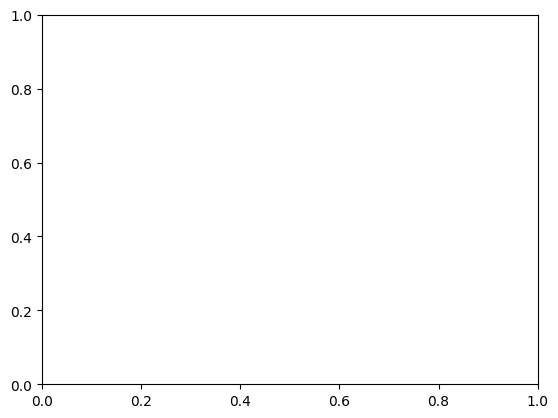

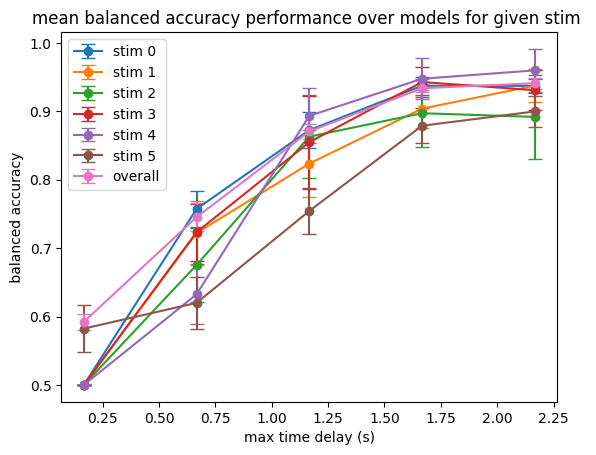

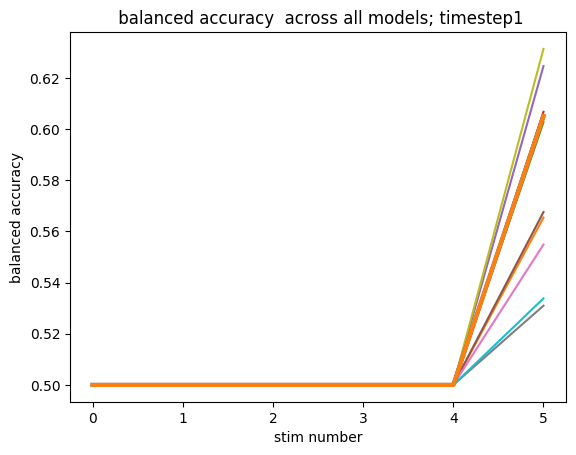

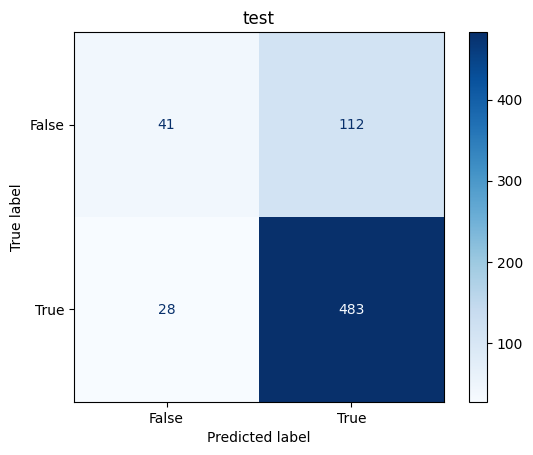

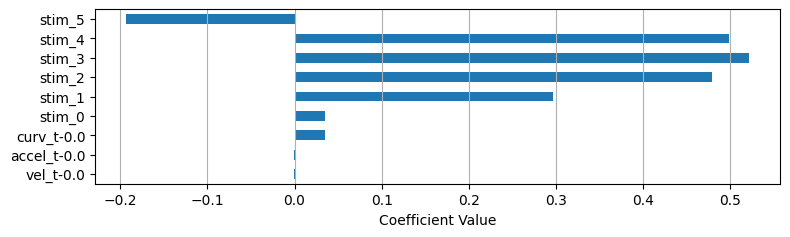

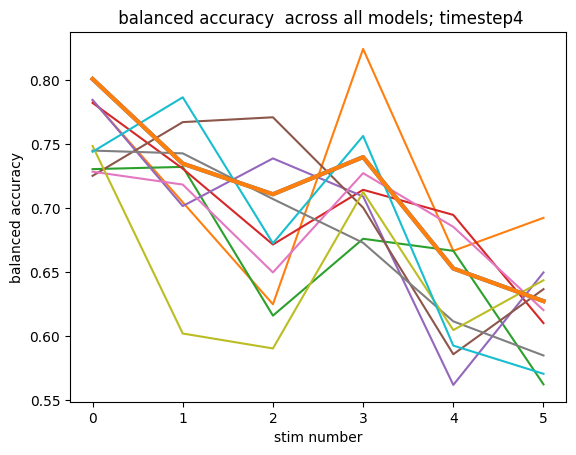

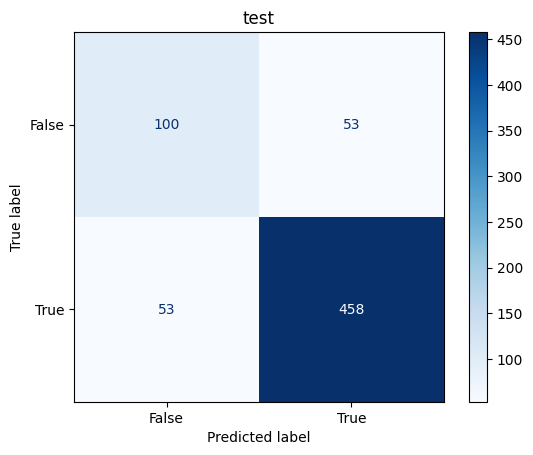

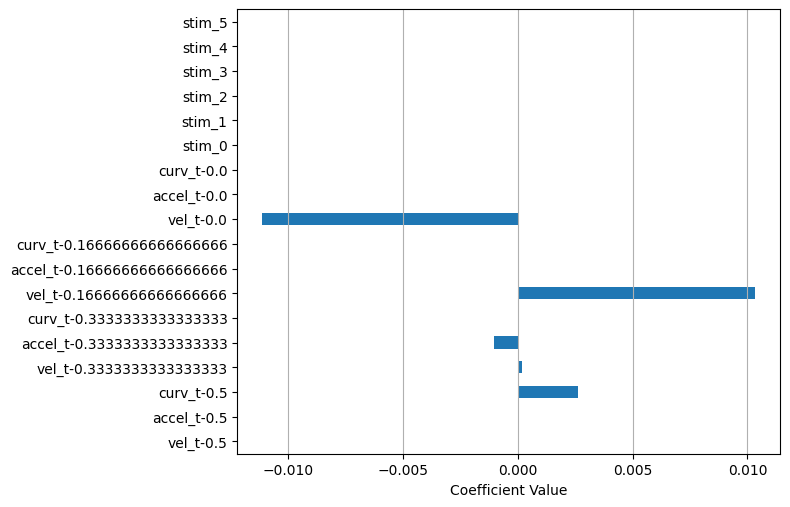

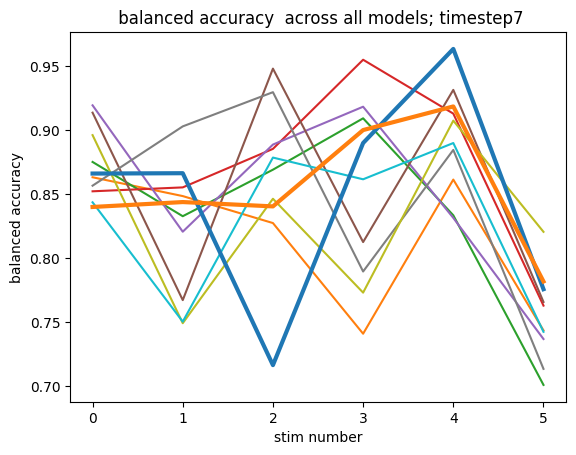

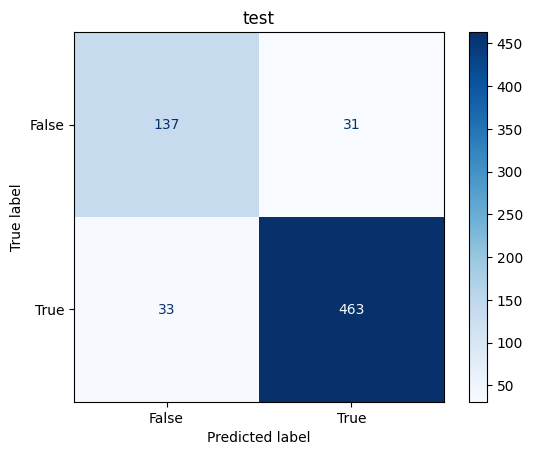

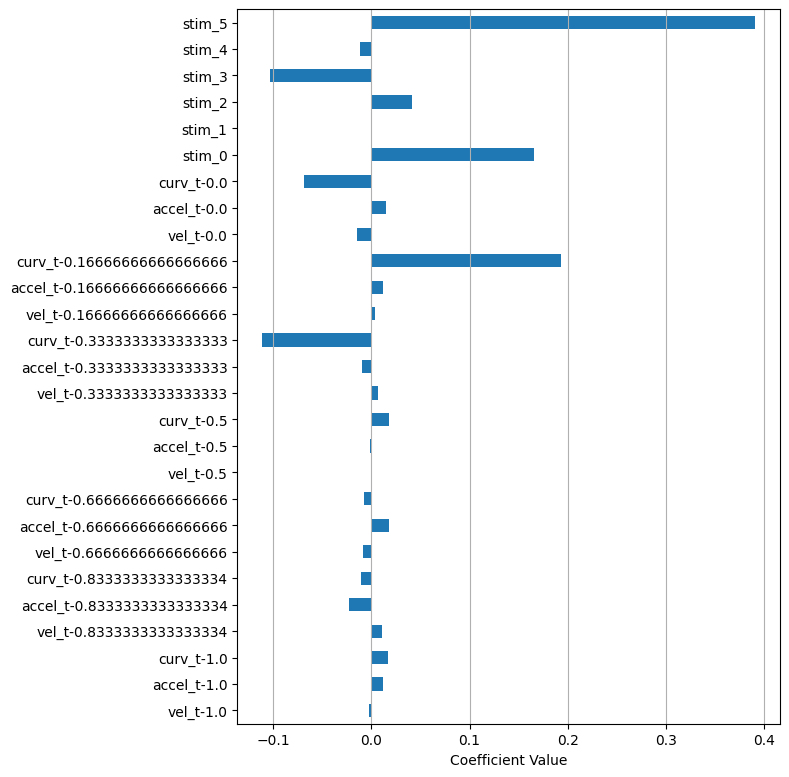

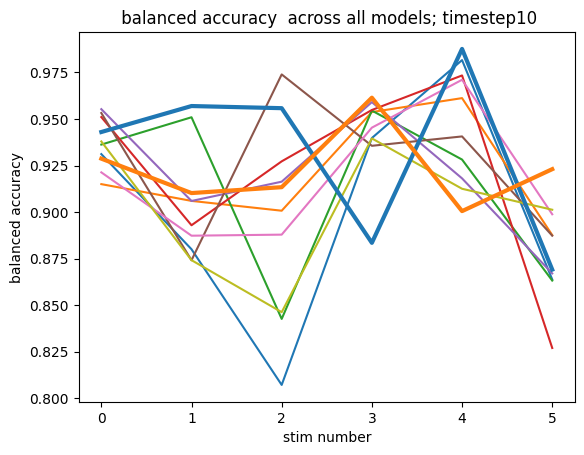

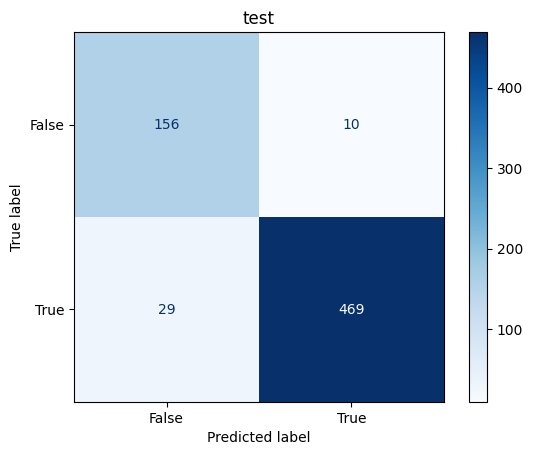

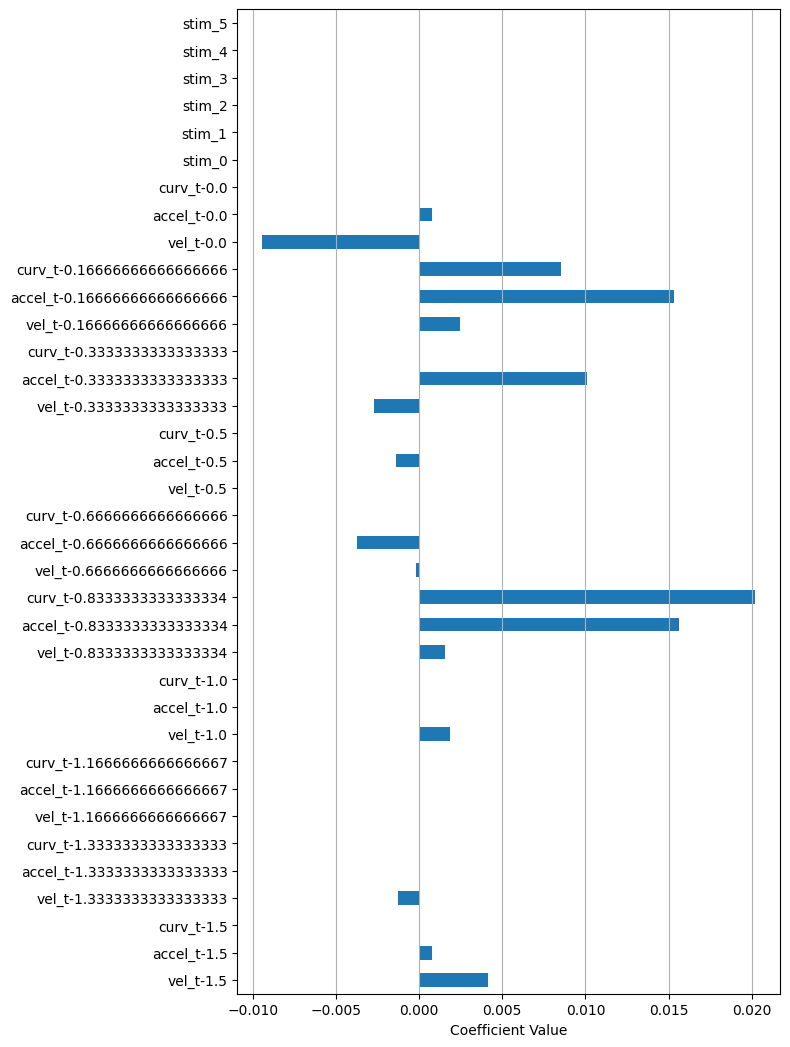

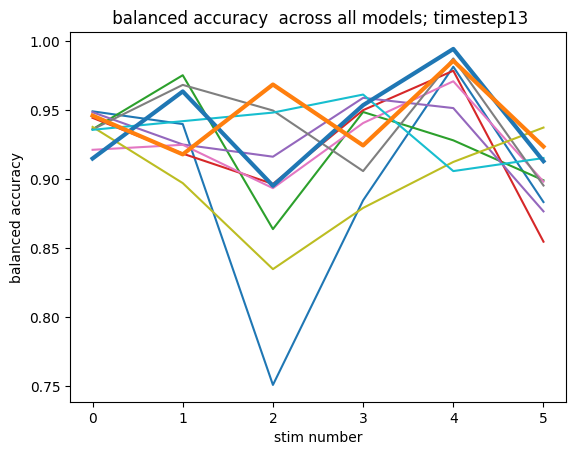

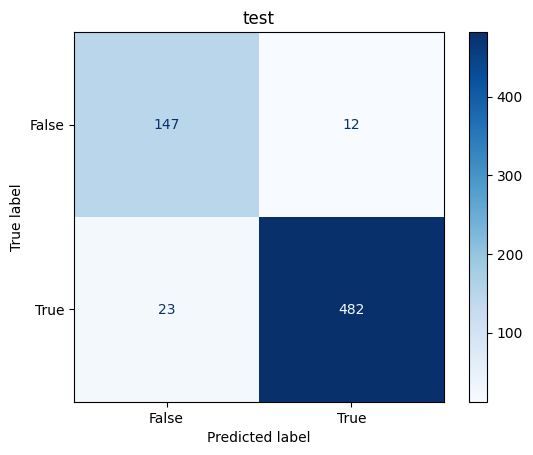

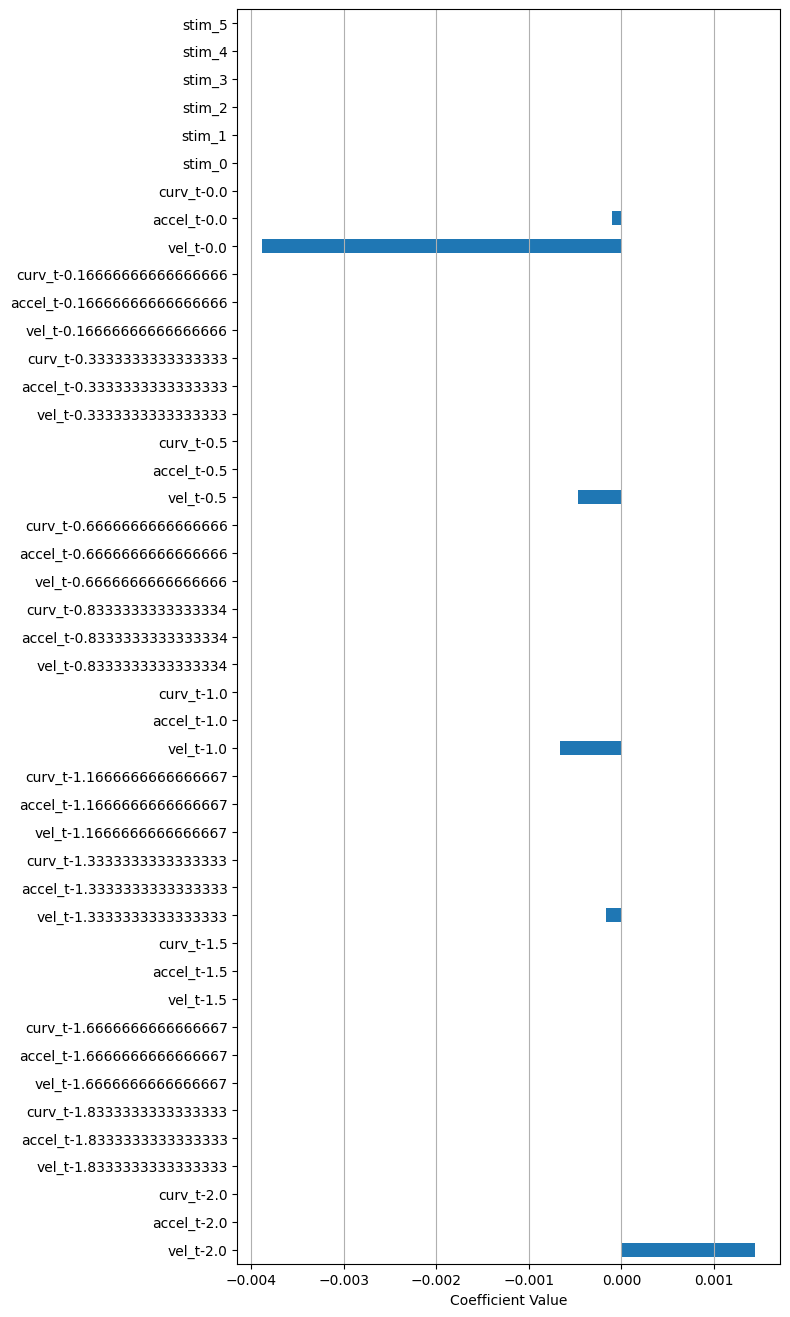

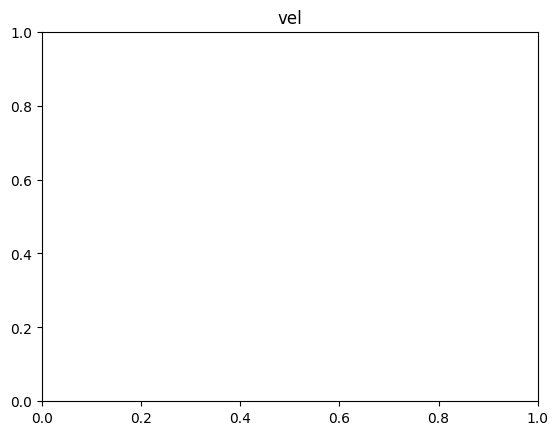

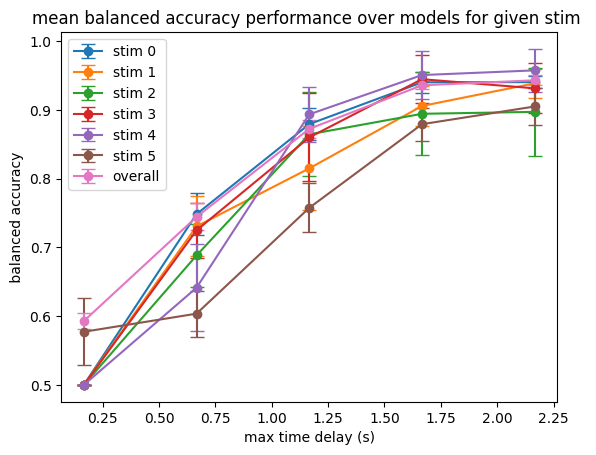

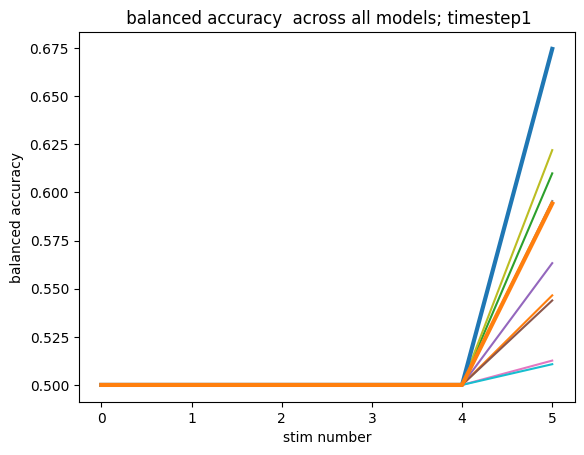

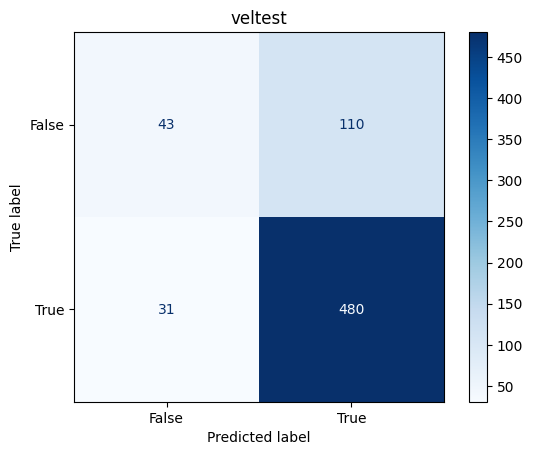

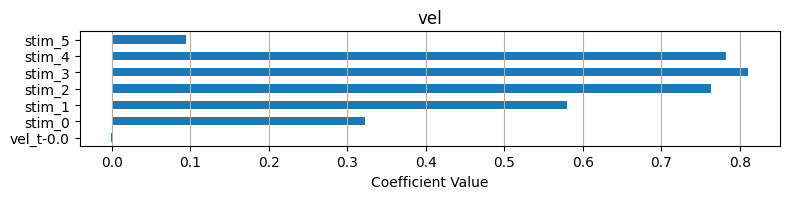

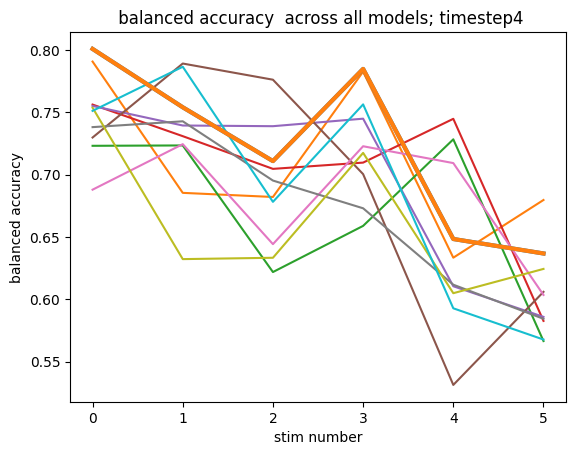

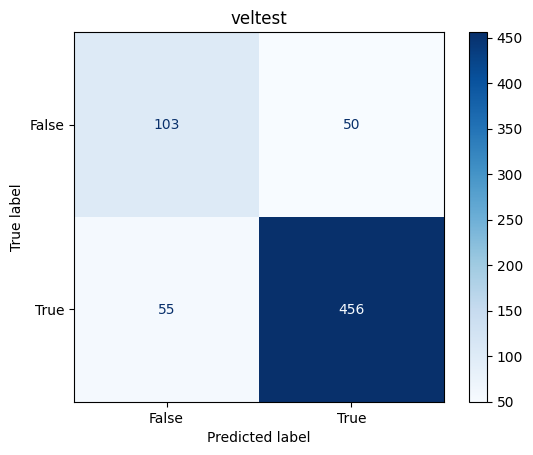

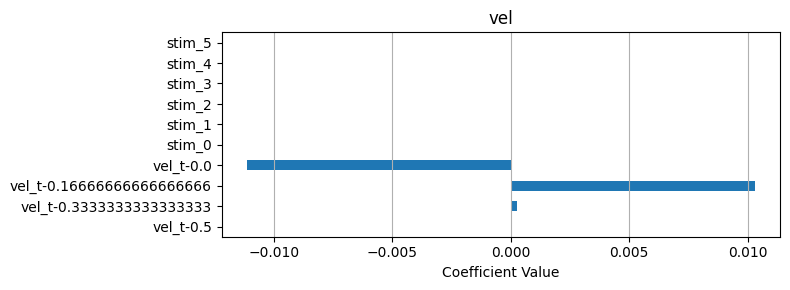

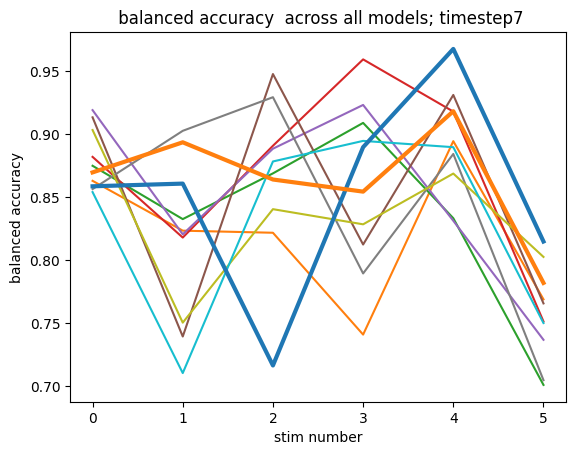

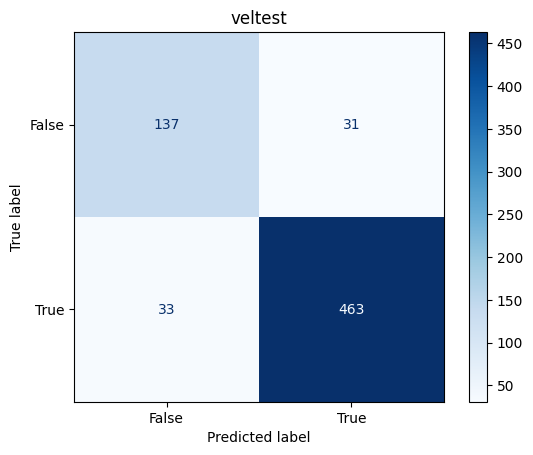

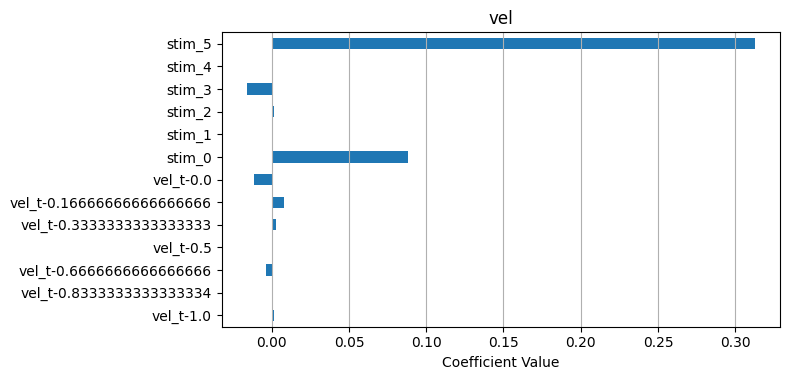

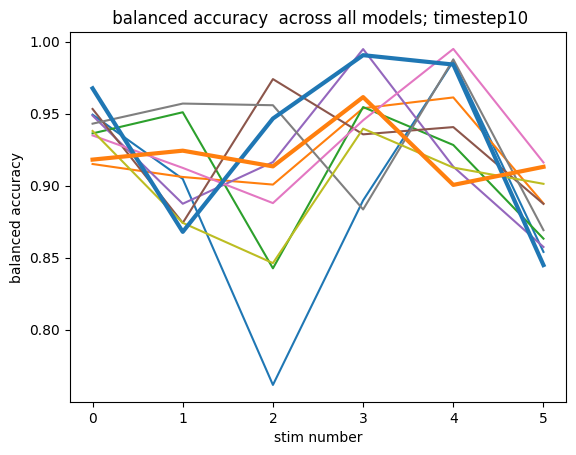

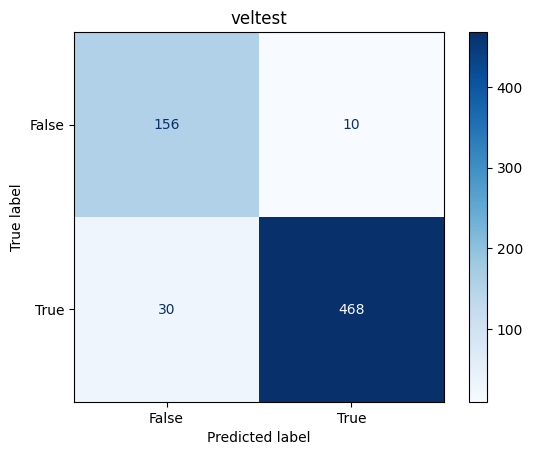

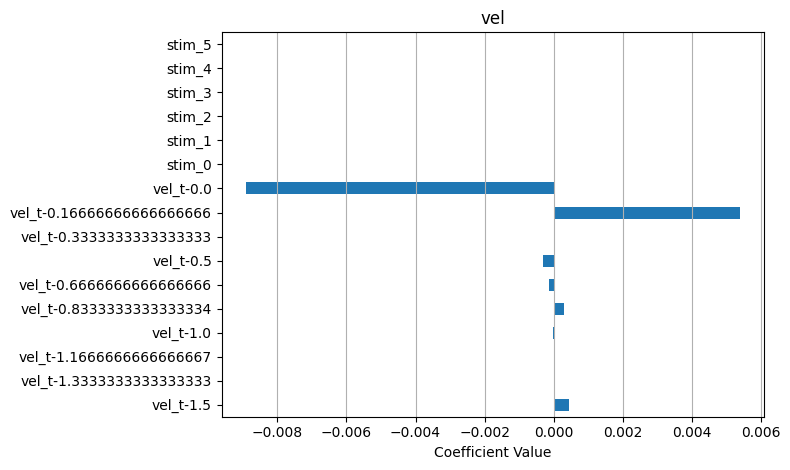

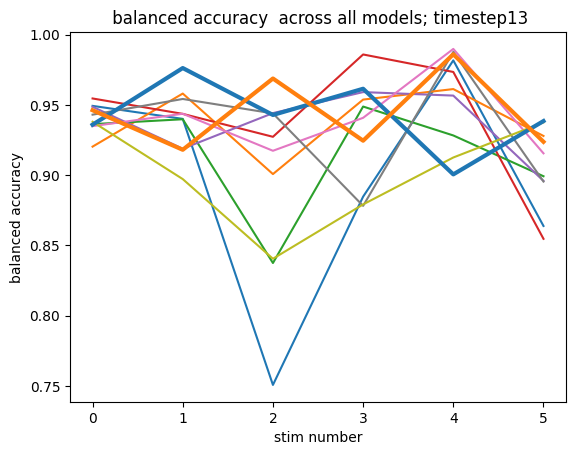

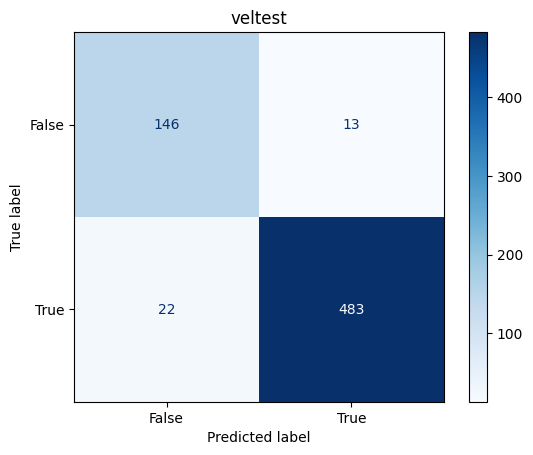

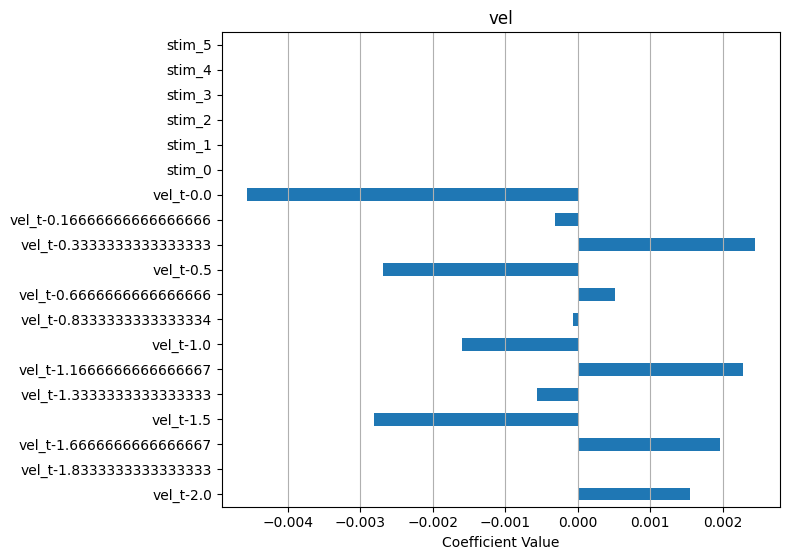

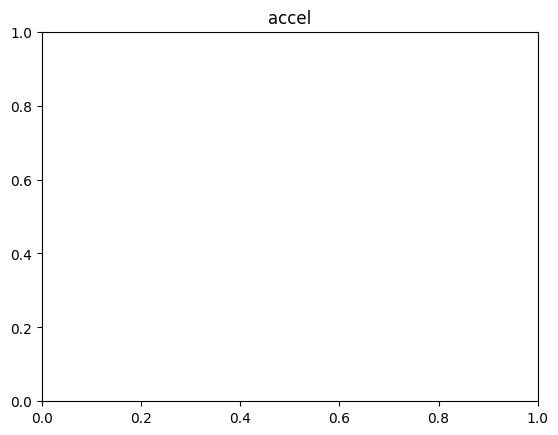

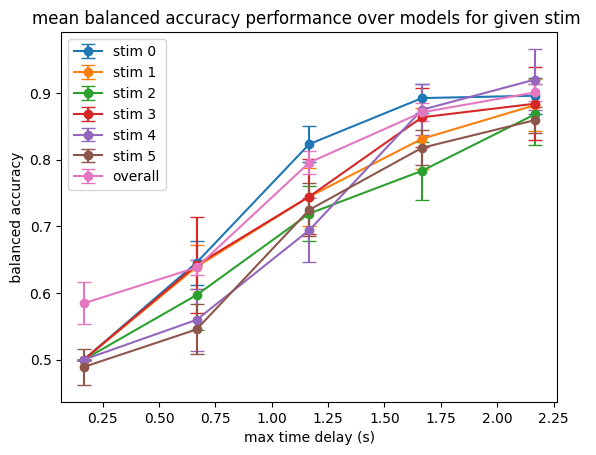

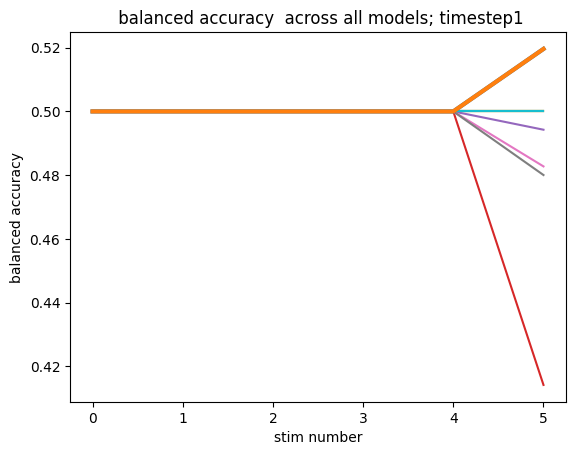

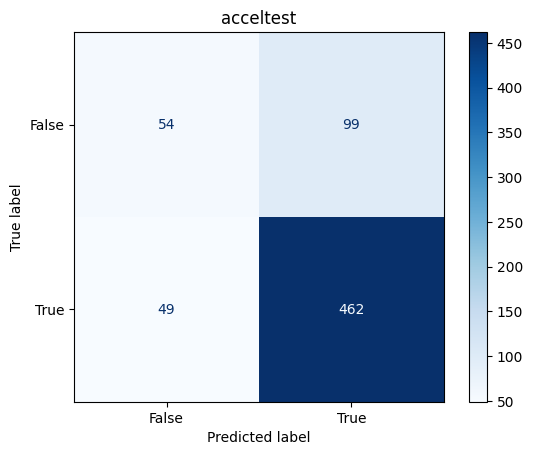

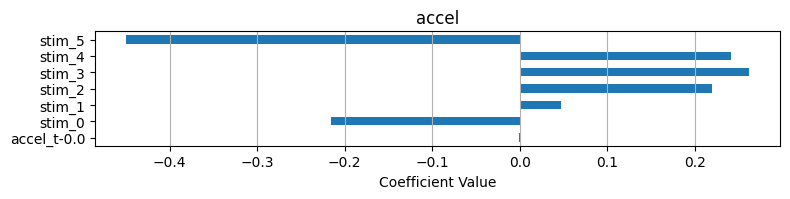

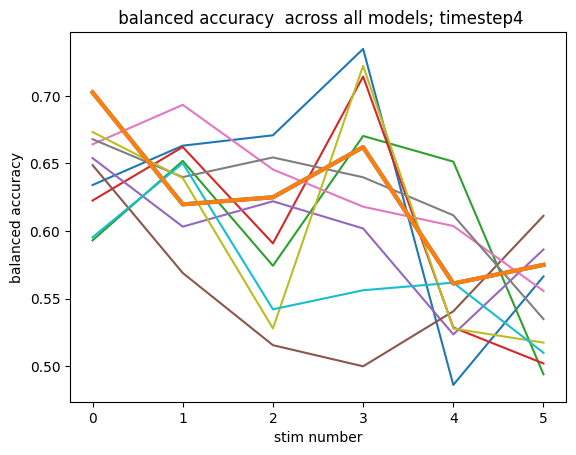

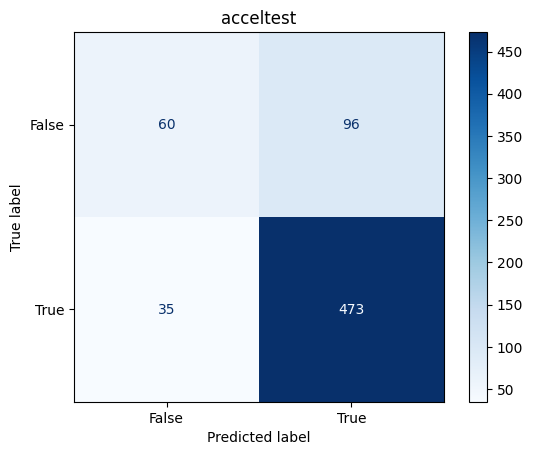

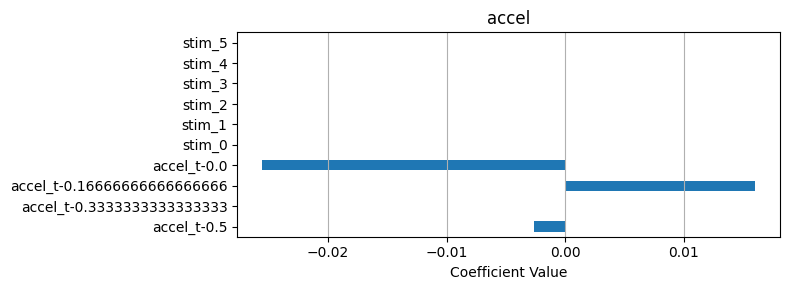

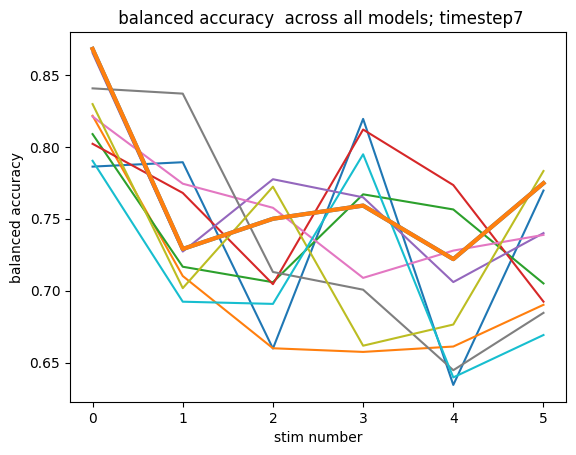

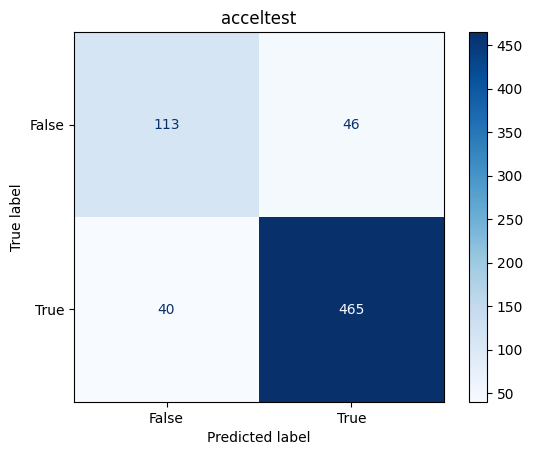

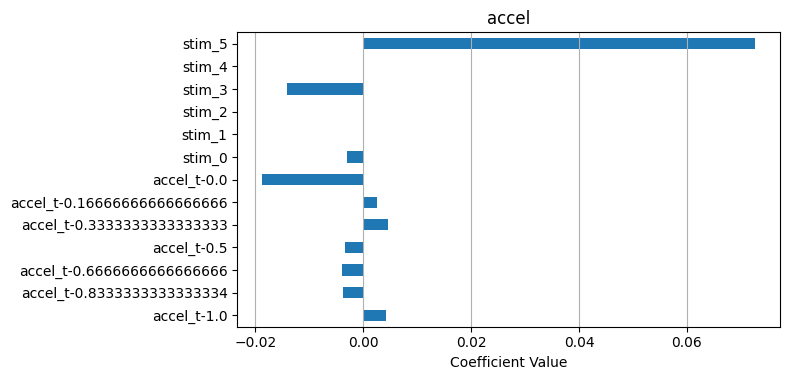

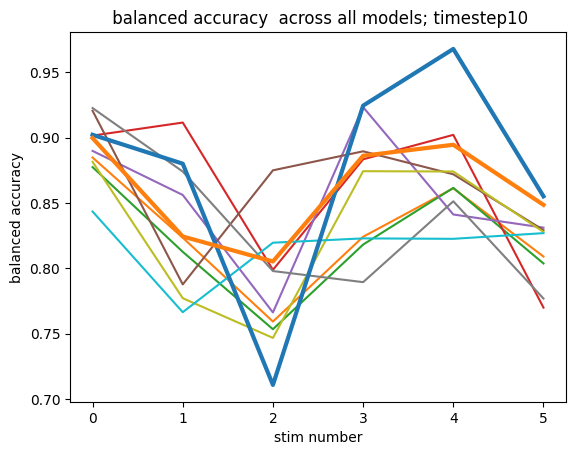

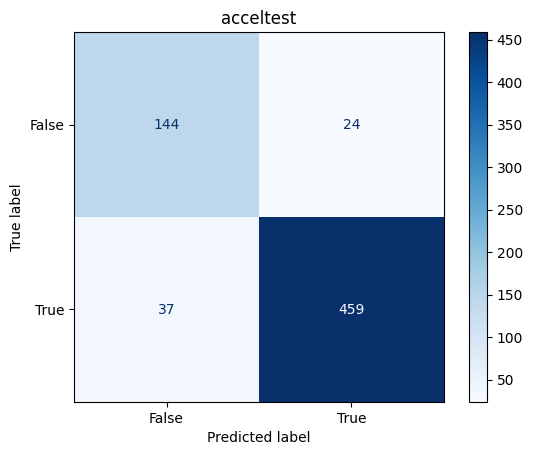

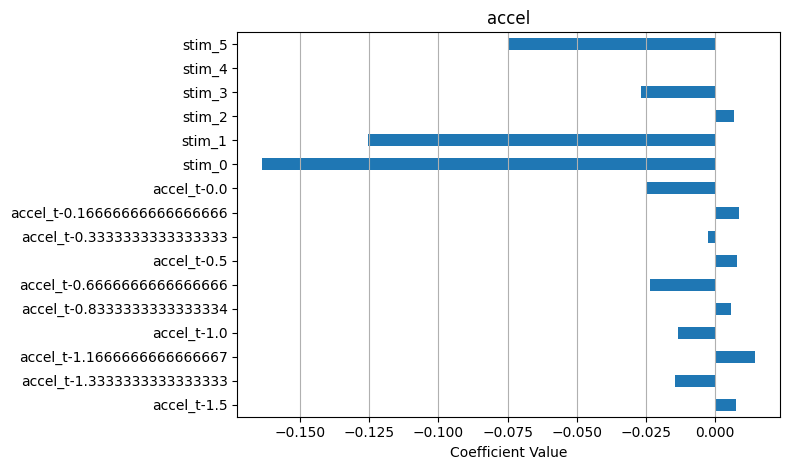

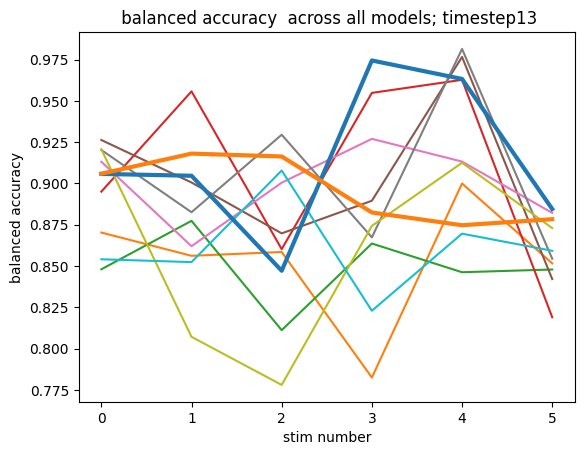

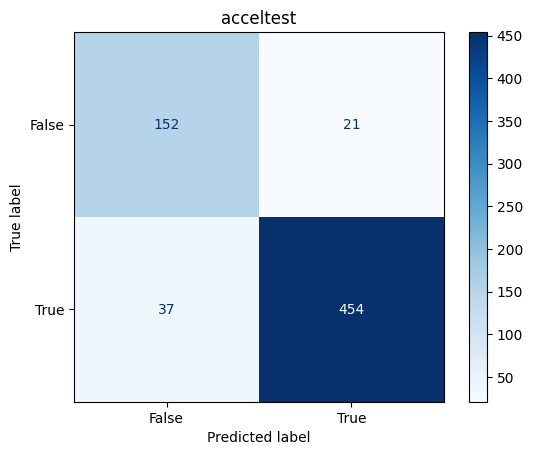

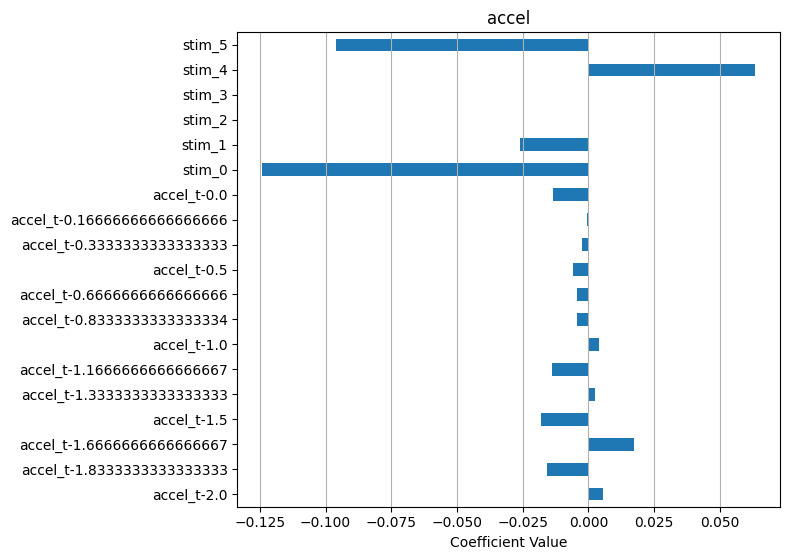

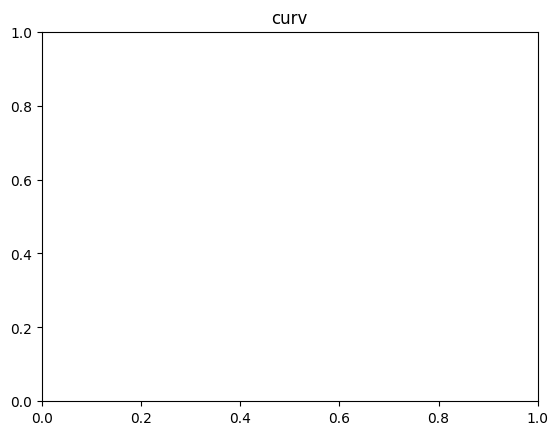

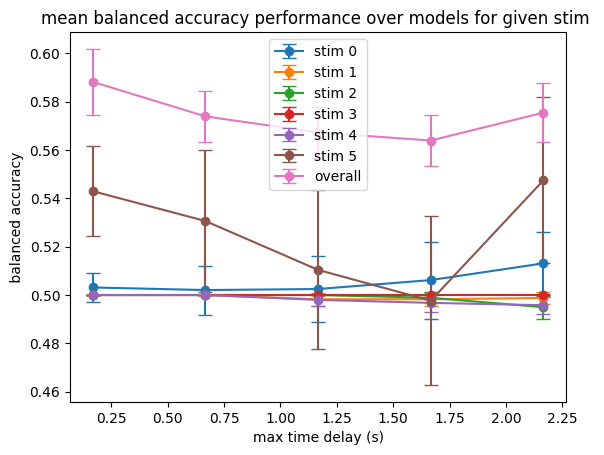

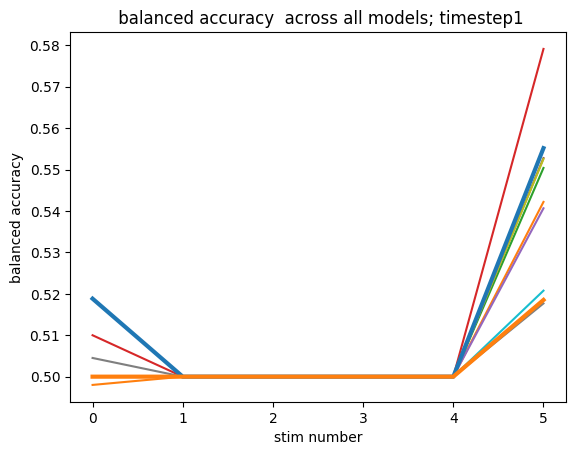

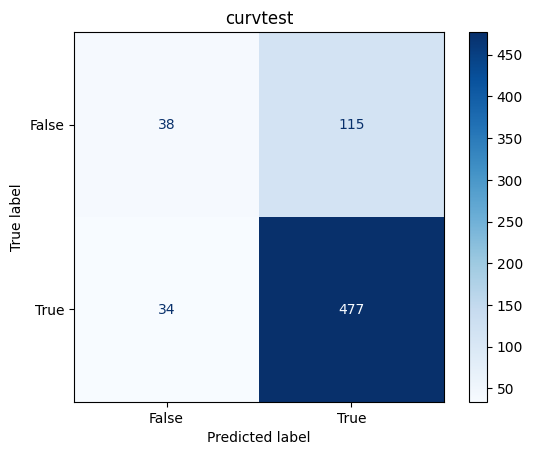

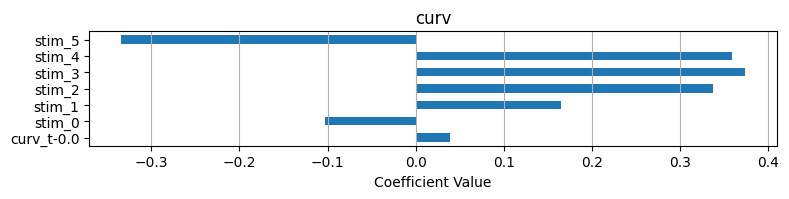

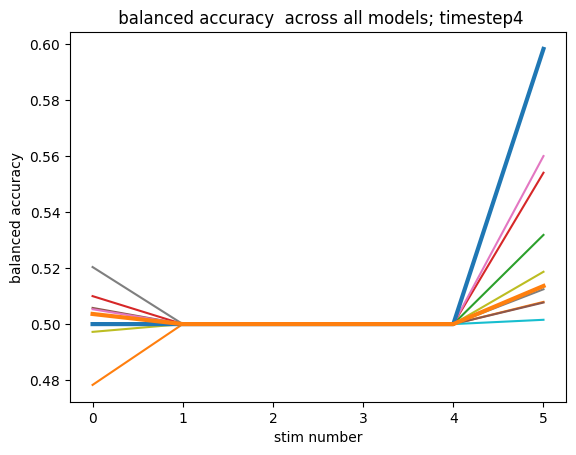

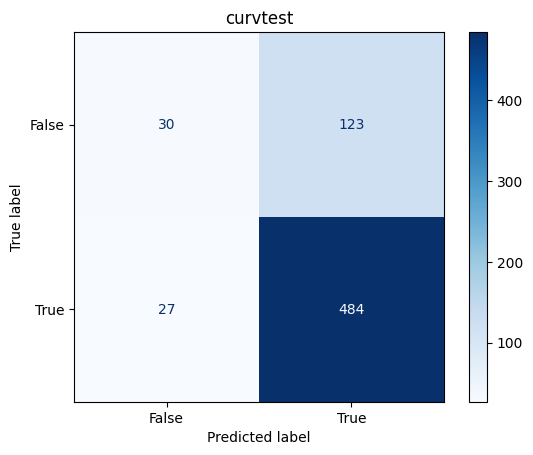

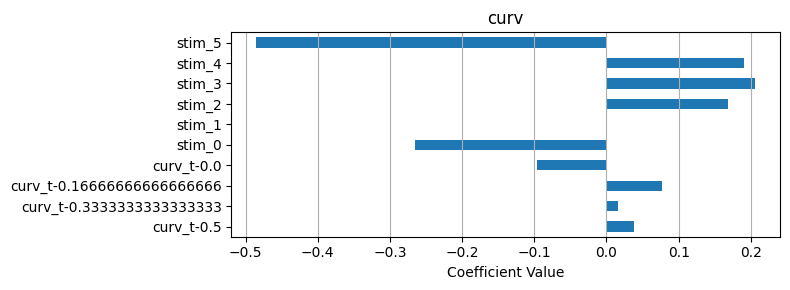

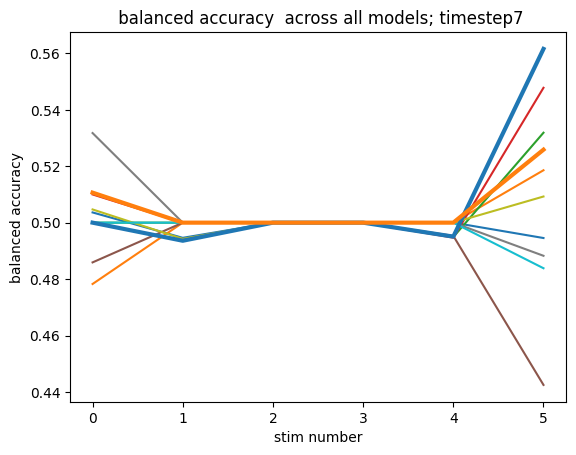

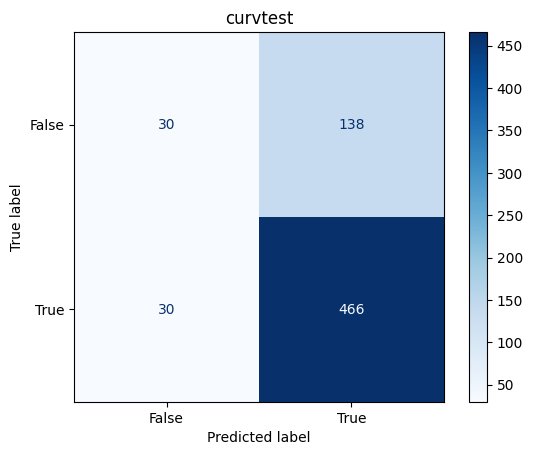

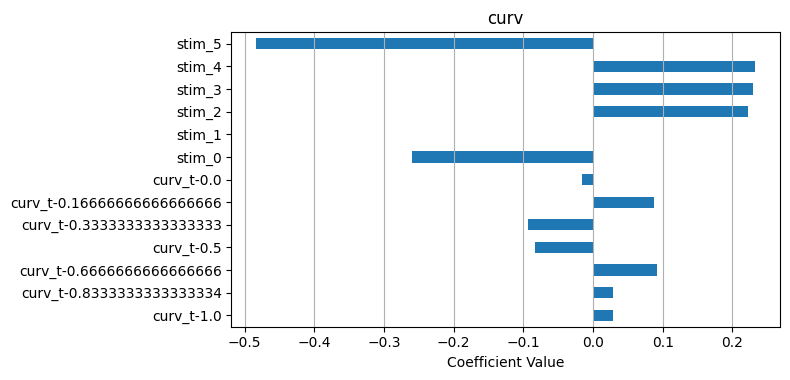

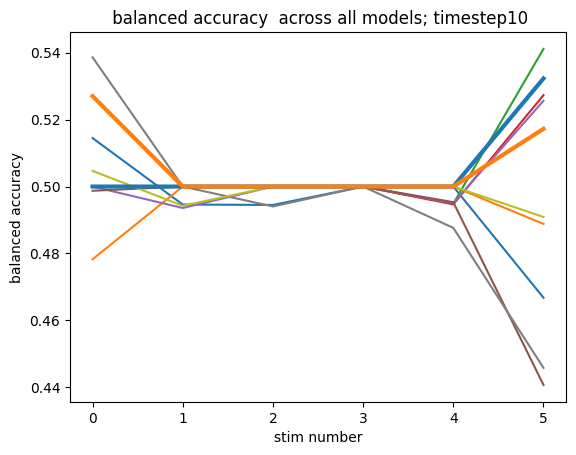

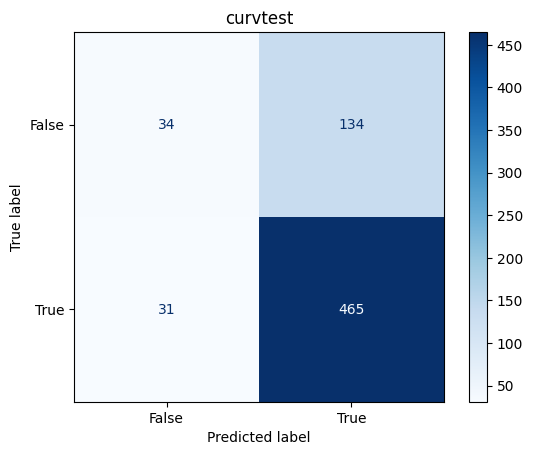

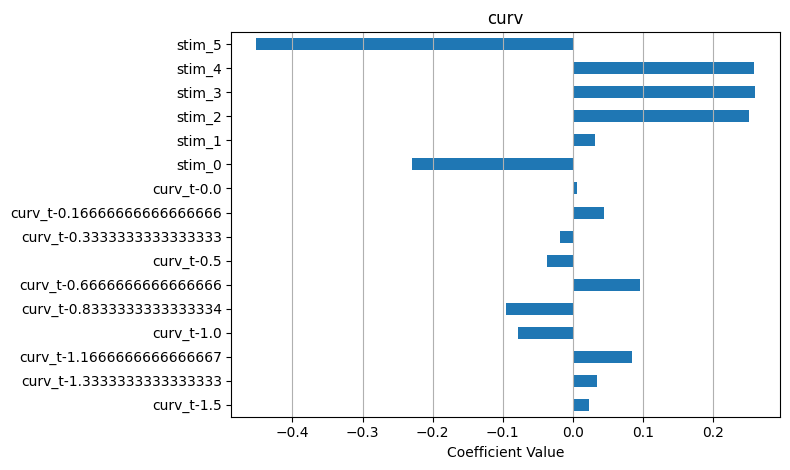

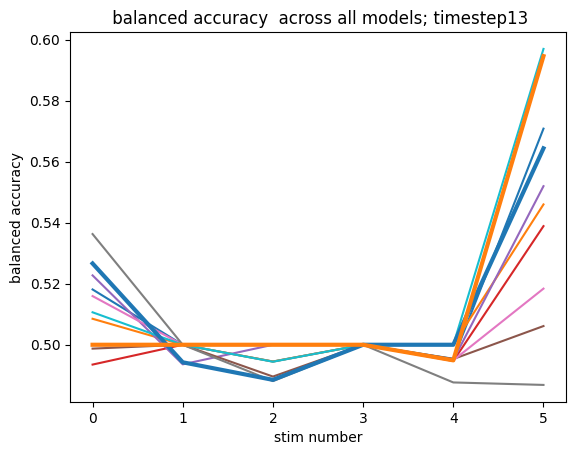

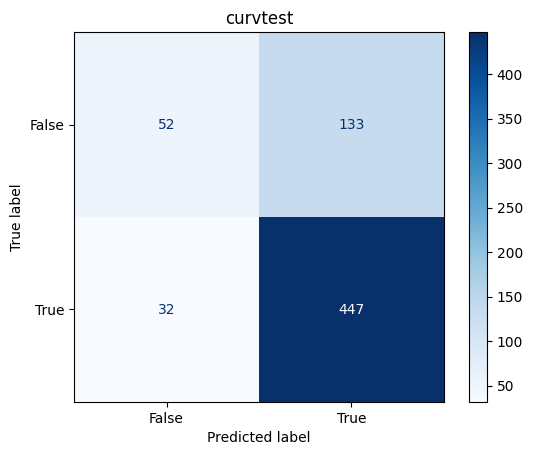

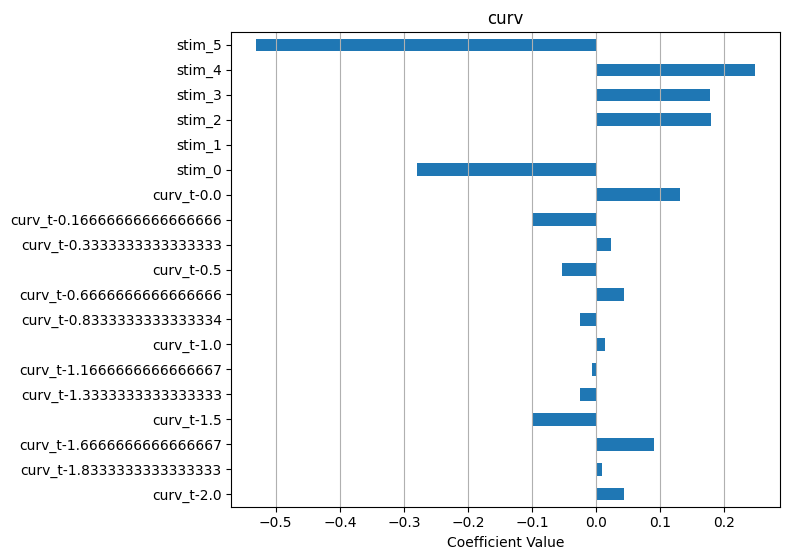

In [125]:
####get rev latency; exp  all beh features exp fps 
feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal prob;\n all features exp fps; Mean ± STD balanced accuracy"
fps = 6
score_label = "balanced accuracy"
score_fnc = balanced_accuracy_score


best_model_score_stim_min, t_to_best_model_using_min_idx_score, t_to_all_data, t_to_all_feature_names  = get_plot_multi_stim_model(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                                        )


title_label = f"{neuron}; Reversal prediction;\n exp fps; all beh features; Mean ± STD balanced accuracy"

feature_to_best_models  = get_plot_multi_stim_model_single_feature(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )

In [ ]:
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
score_fnc = r2_score
data_onsets = resampled_onsets
score_label="r2"
title_label = f"{neuron}; Reversal latency;\n all features resamppled; Mean ± STD balanced accuracy"
fps = 1.6

feature_to_best_models  = get_plot_multi_stim_model(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )


title_label = f"{neuron}; Reversal latency;\n single features; Mean ± STD balanced accuracy"


feature_to_best_models  = get_plot_multi_stim_model_single_feature(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )

In [ ]:


feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = exp_onsets
score_label="r2"
score_fnc = r2_score
title_label = f"{neuron}; Reversal latency;\n all features exp fps; Mean ± STD balanced accuracy"
fps = 6
feature_to_best_models  = get_plot_multi_stim_model(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )


title_label = f"{neuron}; Reversal latency;\n single features exp fps; Mean ± STD balanced accuracy"


feature_to_best_models  = get_plot_multi_stim_model_single_feature(
                                                    data_prep_fnc,
                                                    model_fit_fnc, 
                                                    result_visualization_fnc, 
                                                    feature_list, 
                                                    feature_labels,
                                                    z, 
                                                    data_onsets,
                                                    exp_onsets, 
                                                    exp_rev, 
                                                    durations,
                                                    fps,
                                                    # title_label,
                                                    score_fnc, 
                                                    test_size = 0.3, 
                                                    n_splits = 10, 
                                                    lstm_lag = 0, 
                                                    score_label=score_label, 
                                                    visualize_individ_stim = False, 

                                                    all_timesteps = None, 
                                                    check_warnings = True
                                                    )

In [ ]:
####get rev prob; resampled  all beh feature s
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal prediction;\n resampled; all beh features; Mean ± STD balanced accuracy"
fps = 1.6
train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )
   

In [ ]:
####get rev prob; resampled  single feature 
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal prediction;\n resampled; single beh features; Mean ± STD balanced accuracy"
fps = 1.6
train_model_single_feature(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0
                           )


In [ ]:
########
####get rev latency; exp  all beh features exp fps 
feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]

data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal prob;\n all features exp fps; Mean ± STD balanced accuracy"
fps = 6
train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )



In [ ]:

####get rev latency; exp  single beh features exp fps 
feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]

data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal prob;\n  single features exp fps; Mean ± STD balanced accuracy"
fps = 6
train_model_single_feature(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )



In [ ]:
####get rev prob; resampled  phase 

n_tracks = resampled_rev.shape[0]
phase_resampled = feature_all_to_resampled(inferred_phases_all, n_tracks)
radii_resampled =  feature_all_to_resampled(inferred_rad_all, n_tracks)
feature_list = [phase_resampled, radii_resampled]
feature_labels = ["phase", "radii"]
data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal prediction; phase and radii resampled\n Mean ± STD balanced accuracy"
fps = 1.6

train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )


In [ ]:
####get rev prob; exp phase  resampled  all beh feature s
exp_phase_high_fps = resample_2d(phase_resampled, target_fps=6, original_fps=1.6)
exp_rad_high_fps = resample_2d(radii_resampled, target_fps=6, original_fps=1.6)
feature_list = [exp_phase_high_fps, exp_rad_high_fps]
feature_labels = ["phase", "radii"]

data_prep_fnc = prep_data_rev_prob
model_fit_fnc = fit_eval_linearSVC
result_visualization_fnc = visualize_model_classification
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal prob;\n phase and radiii exp fps; Mean ± STD balanced accuracy"
fps = 6
lstm_lag = 0

train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = lstm_lag, 
                               single_feature = False, 
                            )


   

In [ ]:

import warnings
from sklearn import metrics


####get rev latency; resampled  all beh feature s
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal latency;\n all features resamppled; Mean ± STD balanced accuracy"
fps = 1.6
train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )

####get rev prob; resampled  single feature 
feature_list = [resampled_vel, resampled_acc, resampled_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal latency;\n single features resampled;  Mean ± STD balanced accuracy"
fps = 1.6
train_model_single_feature(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0
                           )

########
####get rev latency; exp  all beh features exp fps 
feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal latency;\n all features exp fps; Mean ± STD balanced accuracy"
fps = 6
train_model_feature_list(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )


####get rev latency; exp  single beh features exp fps 
feature_list = [exp_vel, exp_acc, exp_curve]
feature_labels = ["vel", "accel", "curv"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal latency;\n  single feature exp fps; Mean ± STD balanced accuracy"
fps = 6
train_model_single_feature(data_prep_fnc,
                               model_fit_fnc, 
                               result_visualization_fnc, 
                               feature_list, 
                               feature_labels,
                               z, 
                               data_onsets,
                               exp_onsets, 
                               exp_rev, 
                               durations,
                               fps,
                               title_label,
                               test_size = 0.3, 
                               n_splits = 10, 
                               lstm_lag = 0, 
                               single_feature = False, 
                              #  rev_bin = resampled_rev
                            )



#########
####get rev prob; resampled  phase 
n_tracks = resampled_rev.shape[0]
phase_resampled = feature_all_to_resampled(inferred_phases_all, n_tracks)
radii_resampled =  feature_all_to_resampled(inferred_rad_all, n_tracks)
feature_list = [phase_resampled, radii_resampled]
feature_labels = ["phase", "radii"]
data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = resampled_onsets
title_label = f"{neuron}; Reversal latency; phase and radii resampled; Mean ± STD balanced accuracy"
fps = 1.6

with warnings.catch_warnings():
  train_model_feature_list(data_prep_fnc,
                                model_fit_fnc, 
                                result_visualization_fnc, 
                                feature_list, 
                                feature_labels,
                                z, 
                                data_onsets,
                                exp_onsets, 
                                exp_rev, 
                                durations,
                                fps,
                                title_label,
                                test_size = 0.3, 
                                n_splits = 10, 
                                lstm_lag = 0, 
                                single_feature = False, 
                                #  rev_bin = resampled_rev
                              )

####get rev latency; exp phase 
exp_phase_high_fps = resample_2d(phase_resampled, target_fps=6, original_fps=1.6)
exp_rad_high_fps = resample_2d(radii_resampled, target_fps=6, original_fps=1.6)
feature_list = [exp_phase_high_fps, exp_rad_high_fps]
feature_labels = ["phase", "radii"]

data_prep_fnc = prep_data_latency
model_fit_fnc = fit_eval_lasso
result_visualization_fnc = visualize_model_regression
data_onsets = exp_onsets
title_label = f"{neuron}; Reversal latency; phase and radii\n Mean ± STD balanced accuracy"
fps = 6
lstm_lag = 0


with warnings.catch_warnings():
  train_model_feature_list(data_prep_fnc,
                                model_fit_fnc, 
                                result_visualization_fnc, 
                                feature_list, 
                                feature_labels,
                                z, 
                                data_onsets,
                                exp_onsets, 
                                exp_rev, 
                                durations,
                                fps,
                                title_label,
                                test_size = 0.3, 
                                n_splits = 10, 
                                lstm_lag = lstm_lag, 
                                single_feature = False, 
                              )




In [ ]:
#####run on all stim combined 

feature_lbl vel

Processing i=0, n_timesteps=1
['vel_t-0']
['vel_t-0']

Processing i=1, n_timesteps=1
['vel_t-0']
['vel_t-0']

Processing i=2, n_timesteps=1
['vel_t-0']
['vel_t-0']

Processing i=3, n_timesteps=1
['vel_t-0']
['vel_t-0']

Processing i=4, n_timesteps=1
['vel_t-0']
['vel_t-0']

Processing i=5, n_timesteps=1
['vel_t-0']
['vel_t-0']
feature_lbl accel

Processing i=0, n_timesteps=1
['accel_t-0']
['accel_t-0']

Processing i=1, n_timesteps=1
['accel_t-0']
['accel_t-0']

Processing i=2, n_timesteps=1
['accel_t-0']
['accel_t-0']

Processing i=3, n_timesteps=1
['accel_t-0']
['accel_t-0']

Processing i=4, n_timesteps=1
['accel_t-0']
['accel_t-0']

Processing i=5, n_timesteps=1
['accel_t-0']
['accel_t-0']
feature_lbl curv

Processing i=0, n_timesteps=1
['curv_t-0']
['curv_t-0']

Processing i=1, n_timesteps=1
['curv_t-0']
['curv_t-0']

Processing i=2, n_timesteps=1
['curv_t-0']
['curv_t-0']

Processing i=3, n_timesteps=1
['curv_t-0']
['curv_t-0']

Processing i=4, n_timesteps=1
['curv

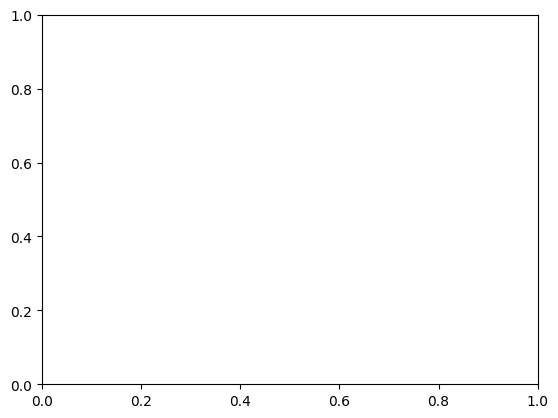

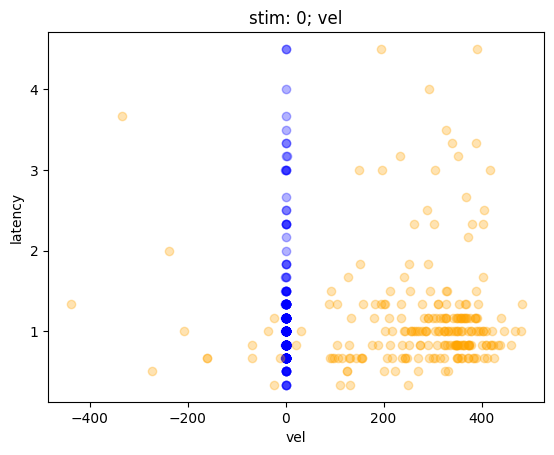

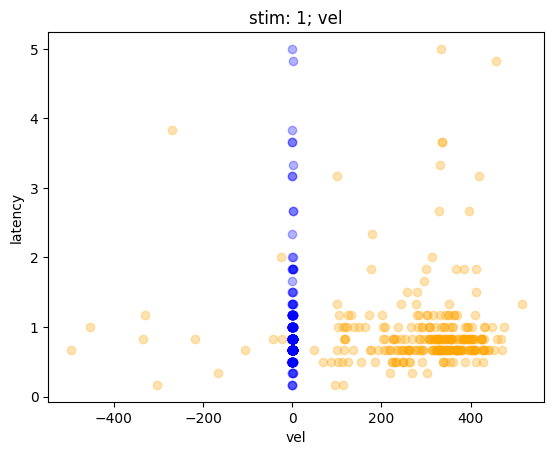

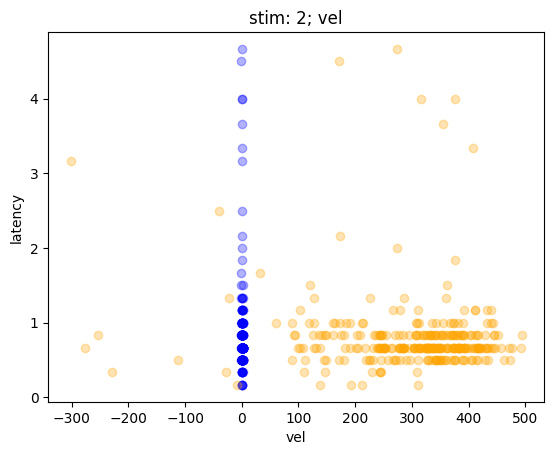

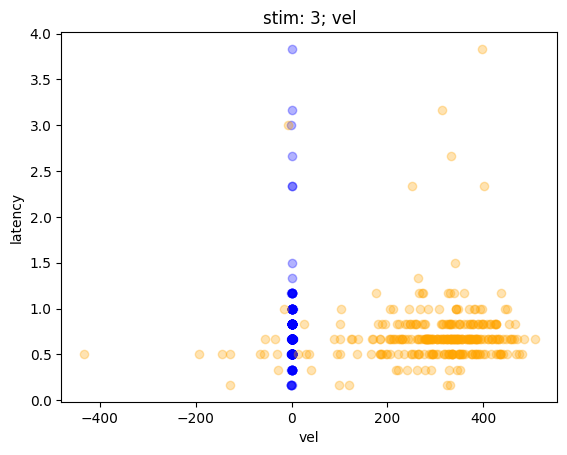

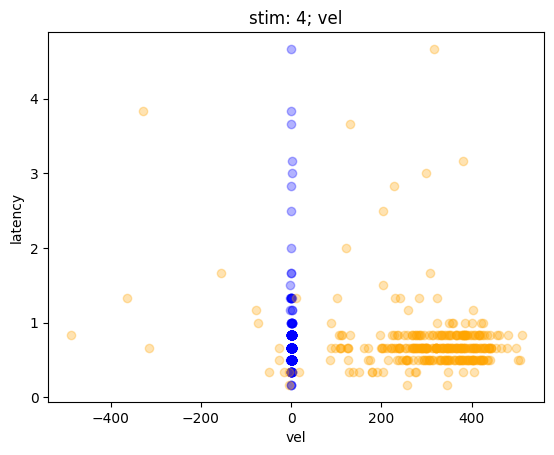

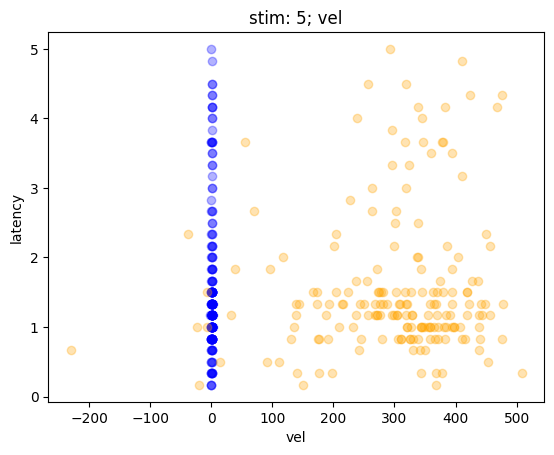

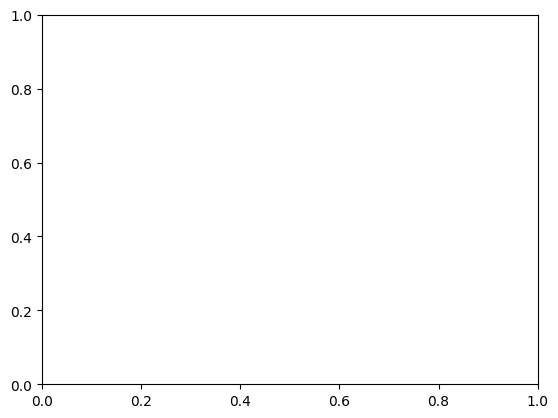

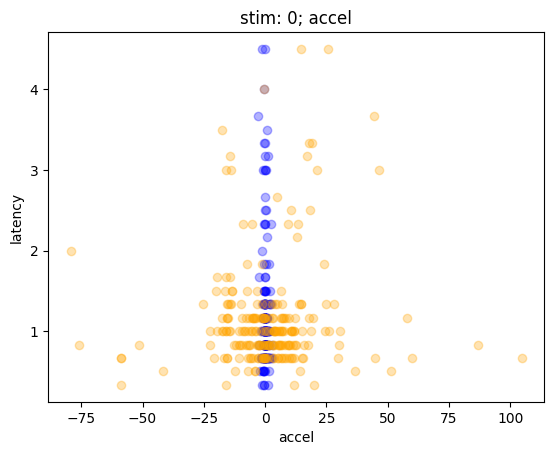

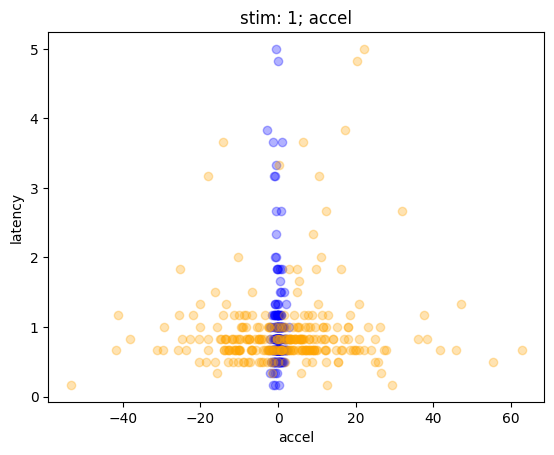

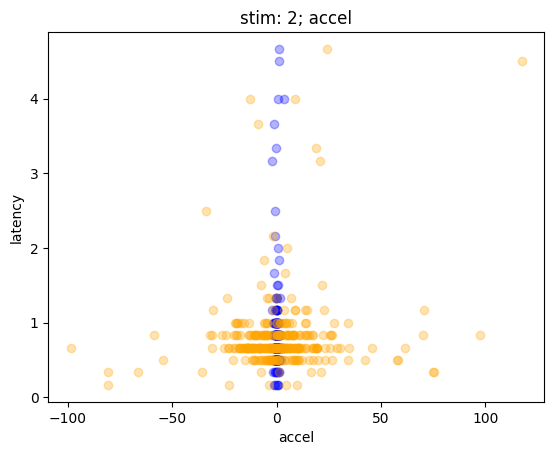

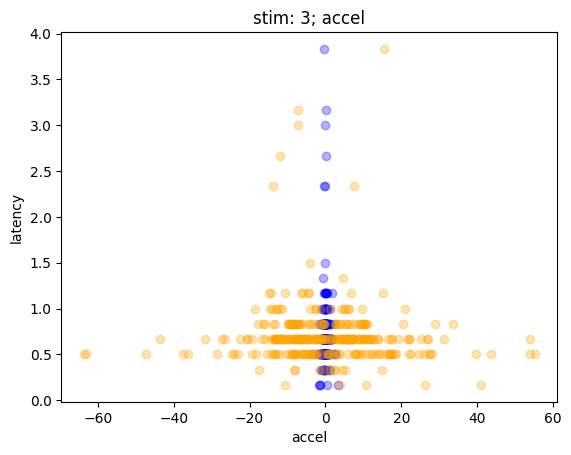

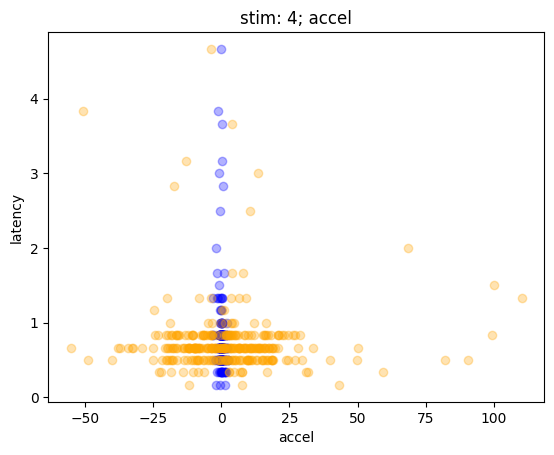

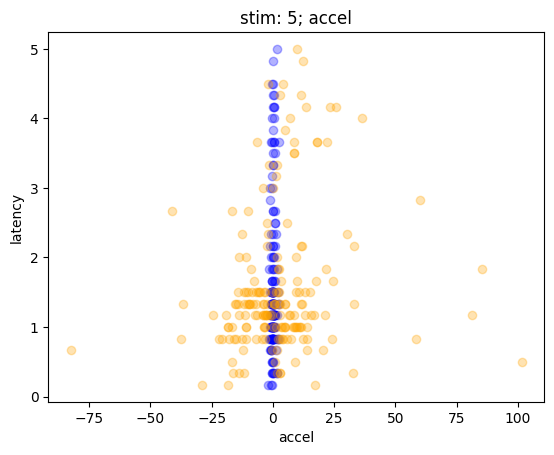

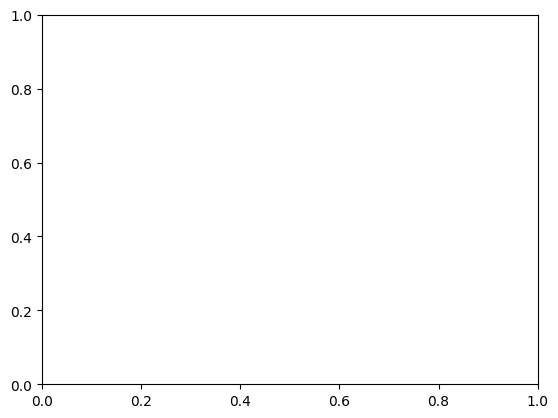

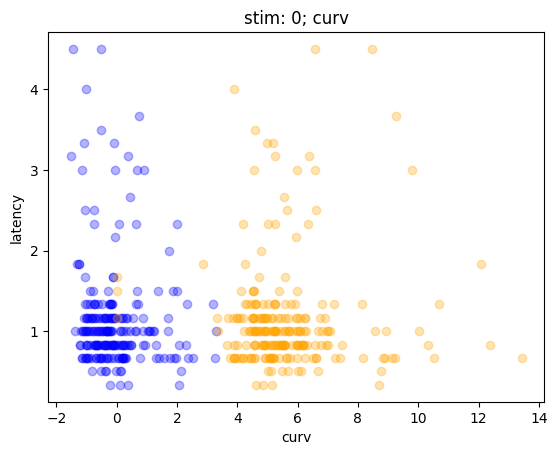

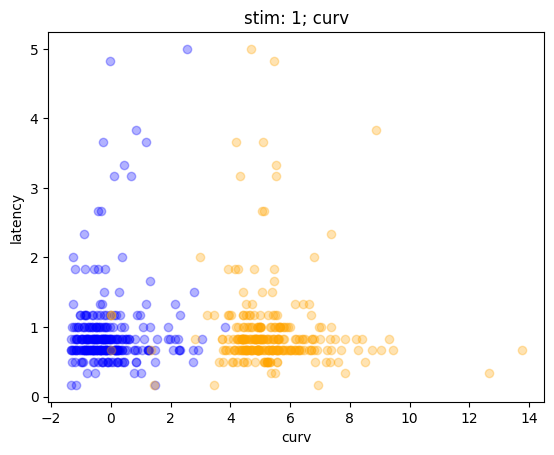

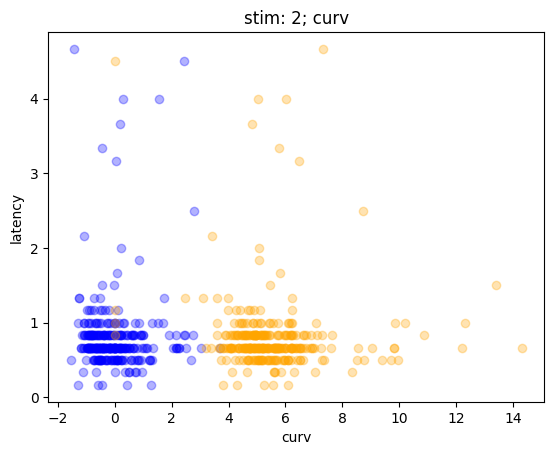

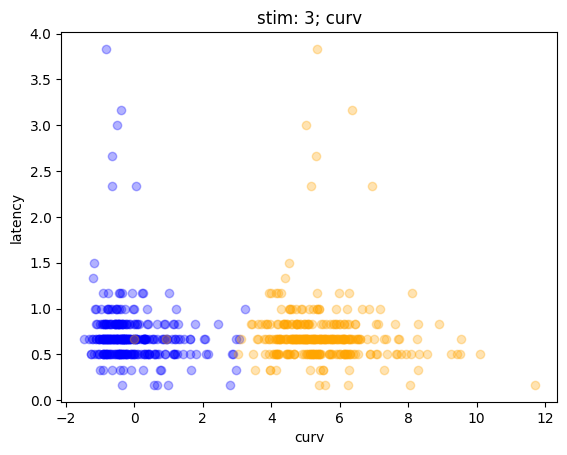

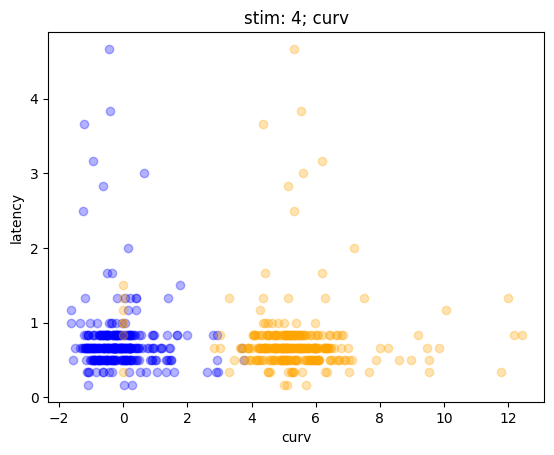

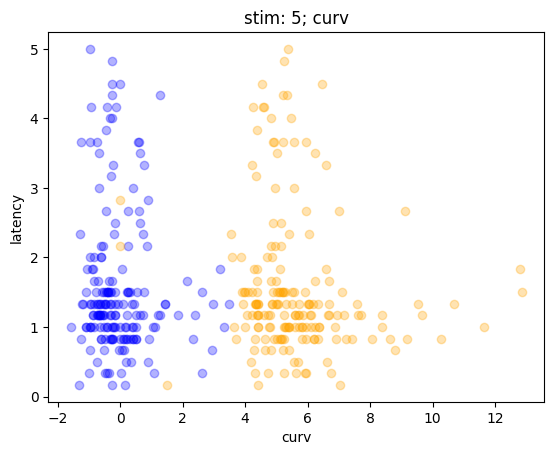

In [ ]:


with warnings.catch_warnings():
        
    # ##get inputs into lstm 
    # beh_map = [z_norm.min(), z_norm.min()/2 + z_norm.max()/2, z_norm.max()]

    warnings.simplefilter("ignore")
    
    for feature, exp_feature, feature_lbl in zip([resampled_vel, resampled_acc, resampled_curve],
                                                 [exp_vel, exp_acc, exp_curve], 
                                                 ["vel", "accel", "curv"]):
        print("feature_lbl", feature_lbl)
        include_beh = False
        n_tracks = resampled_rev.shape[0]
        n_splits = 10
        results_dict = {}  # Store mean/std r² per i and n_timesteps
        best_models = {}   # Store best model per (i, n_timesteps)
        lstm_lag = 0
        idxs = [[0],[1],[2],[3],[4],[5]]
        fig, ax = plt.subplots()
        for i, (resampled_onset, exp_onset) in enumerate(zip(resampled_onsets, exp_onsets)):
            score_means = []
            score_stds = []
            # all_r2_means = []
            all_scores_per_i = {}
            n_timesteps_list = []
            onset = resampled_onset-1
            n_timesteps = 1
            # for n_timesteps in range(1, 15, 3):
            # for n_timesteps in range(1, 15, 1):
            print(f"\nProcessing i={i}, n_timesteps={n_timesteps}")

            # X_stim_all, feature_names_all = prep_FB_inputs_features_only(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, onset, n_timesteps,   lstm_lag = lstm_lag)#shape (n_tracks, n_frames, n_features)
            # X_stim_all, feature_names_all = prep_FB_inputs_features_only(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, onset, n_timesteps, z,  lstm_lag = lstm_lag, include_beh = include_beh)#shape (n_tracks, n_frames, n_features)
            # X_stim_all1, _ = prep_FB_inputs_features_only(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, onset, n_timesteps, z,  lstm_lag = lstm_lag, include_beh = include_beh)#shape (n_tracks, n_frames, n_features)
            features_list = [feature]
            feature_labels = [feature_lbl]
            X_stim_all, feature_names_all = prep_FB_inputs_select_features_only(
                # resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn,
                features_list, feature_labels, onset,  n_timesteps, z, lstm_lag = lstm_lag, 
            
                            )
            
            # X_stim_features = X_all_LSTM[:, stim_onset, :]

            
            Y_latency = latency_to_reversal(exp_rev, exp_onset, max_latency = 6*durations[i]+1)/6 # nan where not 
            no_rev_at_onset = Y_latency!=0
            Y_prob = np.logical_not(np.isnan(Y_latency[no_rev_at_onset]))# classfy y/n did rev happen
            X_prob = copy.deepcopy(X_stim_all[no_rev_at_onset])
            Y_latency1 = Y_latency[no_rev_at_onset]
            print(feature_names_all)
            fig, ax = plt.subplots()
            ax.scatter(X_prob.flatten(), Y_latency1, color = "blue", alpha = 0.3)
            
            
            
            
            features_list = [exp_feature]
            feature_labels = [feature_lbl]
            X_stim_all, feature_names_all = prep_FB_inputs_select_features_only(
                # resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn,
                features_list, feature_labels, exp_onset-1,  n_timesteps, z, lstm_lag = lstm_lag, 
            
                            )
            
                        
            Y_latency = latency_to_reversal(exp_rev, exp_onset, max_latency = 6*durations[i]+1)/6 # nan where not 
            no_rev_at_onset = Y_latency!=0
            Y_prob = np.logical_not(np.isnan(Y_latency[no_rev_at_onset]))# classfy y/n did rev happen
            X_prob = copy.deepcopy(X_stim_all[no_rev_at_onset])
            Y_latency1 = Y_latency[no_rev_at_onset]
            print(feature_names_all)
            # fig, ax = plt.subplots()
            
            ax.scatter(X_prob.flatten(), Y_latency1, color = "orange", alpha = 0.3)
            
            
            
            ax.set_title(f"stim: {i}; {feature_lbl}")
            ax.set_xlabel(f"{feature_lbl}")
            ax.set_ylabel(f"latency")
            
        ##plot smoothed phase vss curvature 



In [ ]:
#############
#####check if can infer phase from interpatlated tim ebetwen revs 
##########

import numpy as np
def event_interpolation_fraction(events):
    """
    Input: 1D np.array with 1 where event occurs, 0 elsewhere.
    Output: 
      - -1 at event indices
      - linearly interpolated fraction of time to next event for other positions
    """
    events = np.asarray(events)
    result = np.full_like(events, np.nan, dtype=float)
    event_idxs = np.where(events == 1)[0]

    if len(event_idxs) == 0:
        return result  # no events, return NaNs

    # # Set -1 where events occur
    # result[event_idxs] = -1.0

    # Loop over event pairs to fill in between
    for i in range(len(event_idxs) - 1):
        start = event_idxs[i]
        end = event_idxs[i + 1]
        gap = end - start
        for j in range(1, gap):
            frac = j / gap  # fraction toward the next event
            result[start + j] = frac

    return result

def get_interpolated_time_since_last_reversal(rev_bin):
    n_frames, n_tracks = rev_bin.shape
    interpolated_fwd_time = np.zeros_like(rev_bin)
    for track in range(n_tracks):
        interpolated_fwd_time[:,track] = event_interpolation_fraction(rev_bin[:,track])
        
    return interpolated_fwd_time

# from 
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
######see if can predict phase from time_since_last_rev 
###need to get phase interpolated or somte 
random_state = 30
test_size = 0.3
interpolated_fwds = get_interpolated_time_since_last_reversal(exp_rev)
n_tracks, n_frames_exp = exp_rev.shape


phase_resampled = feature_all_to_resampled(inferred_phases_all, n_tracks)
exp_phase_high_fps = resample_2d(phase_resampled, target_fps=6, original_fps=1.6)
Y = exp_phase_high_fps.flatten()
X = interpolated_fwds.flatten()

non_nan_is = np.argwhere(np.logical_and(np.logical_not(np.isnan(X)), np.logical_not(np.isnan(Y)))).flatten()
X = X[non_nan_is]
X = X.reshape(-1, 1)
Y = Y[non_nan_is]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)


alphas = np.logspace(-4, 2, 20)
model_label= f"lasso"
# lasso = Lasso(max_iter=10000)
model = LinearRegression()
model.fit(X_train, y_train)
# grid_search = GridSearchCV(model, {'alpha': alphas}, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# model = LinearRegression()

n_timesteps = 1
fit_visualize_model_regression(model, model_label, np.array(["interpol"]), X_train, X_test, y_train, y_test, n_timesteps, feature_names_ordered =  np.array(["interpol"]))



In [ ]:
########compare latnecy prediciton feautres single feature  exp fps

In [ ]:
########compare latnecy prediciton time delayed pahse exp fps


In [ ]:
#####fix so doing all with the same model across stim 

# simulate data

In [ ]:
# try: #no need to redo it
#     final_behs
# except:
final_behs = simulate_exp([0,1,3,5], input_durs=[8], neuron=neuron, input_dict = input_dict,new_slds = new_slds, q_x = q_x, pca=pca,  z= z, total_dur=8, thresh=2, remove_rev=False)

NameError: name 'z' is not defined

# plot

(0.0, 40.0)

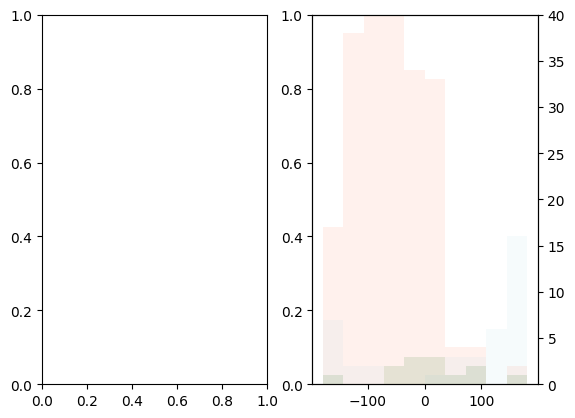

In [ ]:
fig,ax_2 = plt.subplots(1,2)
ax2 = ax_2[1].twinx()
idxs=[0,-1]
transformed_angles = np.degrees(np.concatenate(inferred_phases[[idxs]]))
# transformed_angles = (transformed_angles)%360 - 180
behs = np.concatenate(initial_behaviors[[idxs]])
beh_map = [z_norm.min(), z_norm.min()/2 + z_norm.max()/2, z_norm.max()]
for i in range(3):
    ax2.hist(transformed_angles[np.abs(behs -beh_map[i]) < 0.01], bins=np.linspace(-180,181,11), density=False, alpha=0.1, color=palette[i])
ax2.set_ylim(0,40)

In [ ]:
ax_2[0].set_title(neuron)
colors = [plt.get_cmap("Purples")(i) for i in np.linspace(0, 1, 7)][1:]
colors[0] = (0,0,0,1)



times = onsets
inferred_phases, final_behaviors, final_behaviors_all, inferred_phases_all, inferred_rad_all, behaviors_all, inferred_rad, initial_behaviors, initial_cts_beh, X_all_LSTM = analyze_data(resampled_vel, resampled_acc, resampled_curve, resampled_rev, resampled_turn, times, model_beh_directed, z_norm,input_stats,  z, lag=16, inclusion_thresh = 2, model_type="ff",normalize=False, remove_revs=False)


for i in range(len(final_behs)):
    test_angs = np.concatenate(worm_angles[0:5])
    plot_rev_pro2(np.degrees(test_angs), final_behs[i], np.concatenate(np.array(q_z[0:5])[:,5+T:]), ax=ax_2[0],  label=f"input: {input_str}", color=colors[i], window_size=np.pi/4, plot_type="line", num_bins=10)

if condition == "control":
    plot_rev_pro2(np.degrees(inferred_phases_all[:10000]), final_behaviors_all[:10000], ax=ax_2[1], color="k", window_size=np.pi/4, beh1=False, plot_type="line", num_bins=10)
    ax_2[1].set_title("control")
else:
    plot_results([0,1,2,3], inferred_phases, final_behaviors, combined=False, ax=ax_2[1], colors=colors[:], num_bins=10, window_size=np.pi/4, plot_type="box", noise_level=0)
    ax_2[1].set_title(neuron)


ax_2[0].set_xlabel(r"$\theta$")
ax_2[1].set_xlabel(r"$\theta$")

# ax_2[1].set_xlim(-120,50)
# ax_2[0].set_xlim(-120,50)

fig.tight_layout()


NameError: name 'final_behs' is not defined

# Kernel regression

NameError: name 'final_behs' is not defined

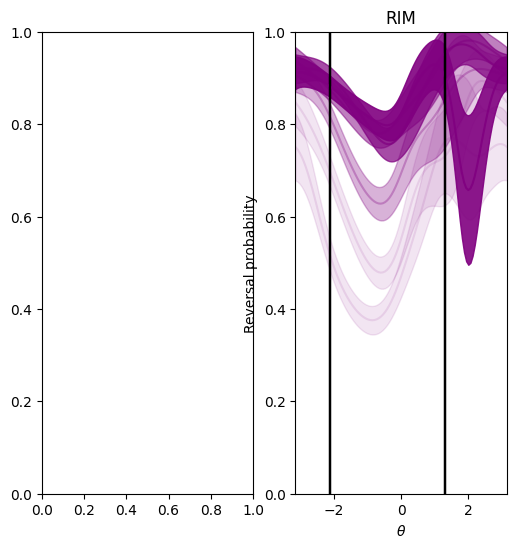

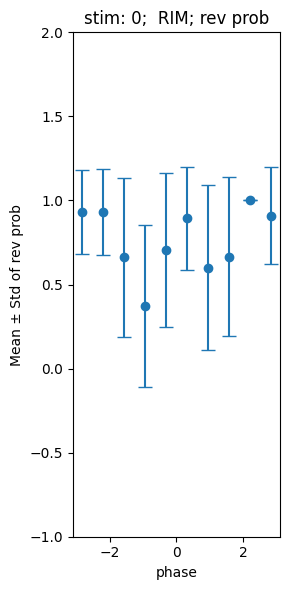

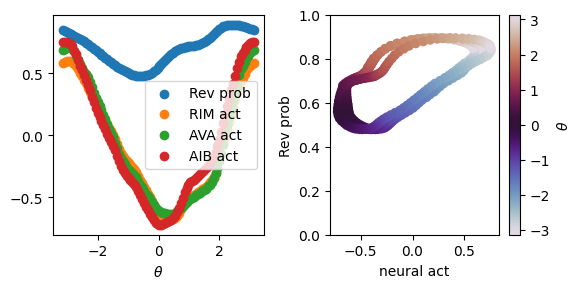

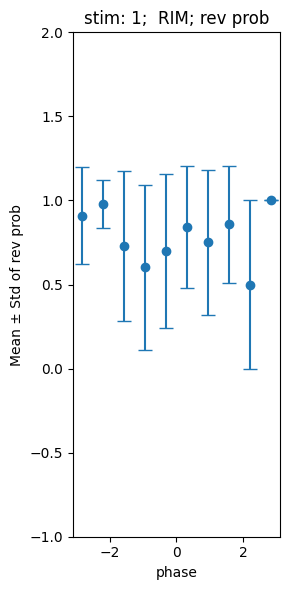

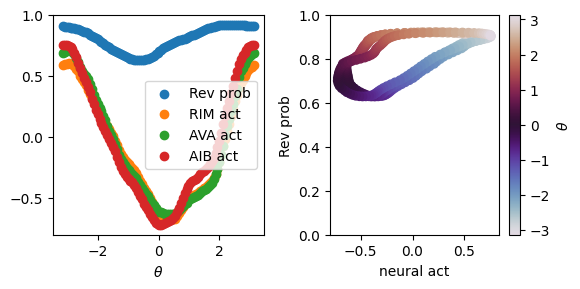

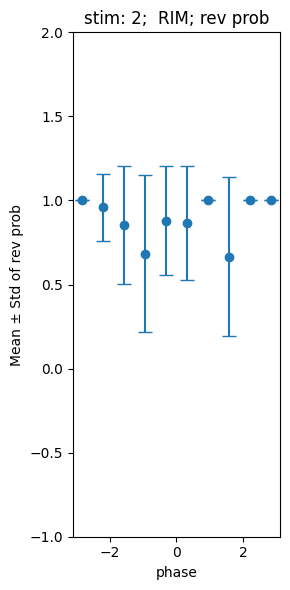

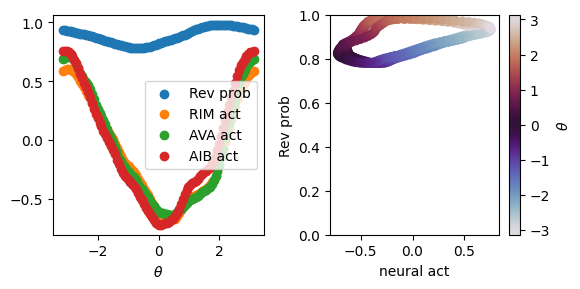

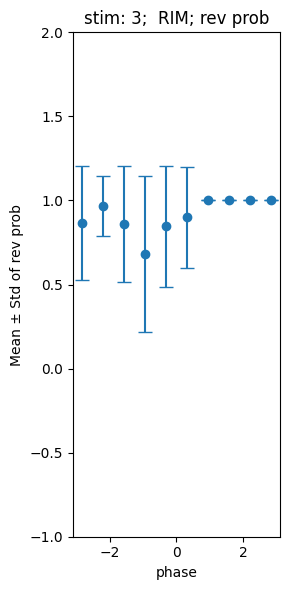

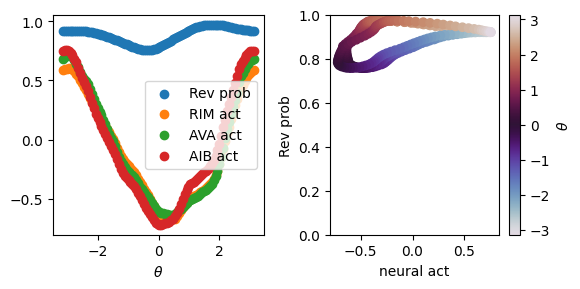

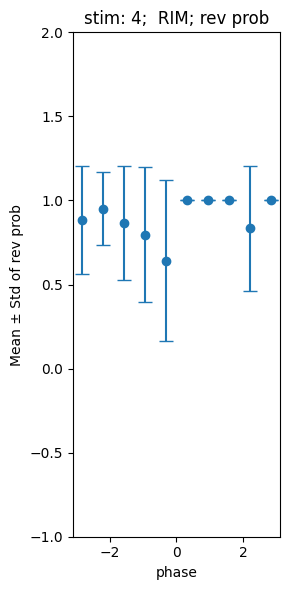

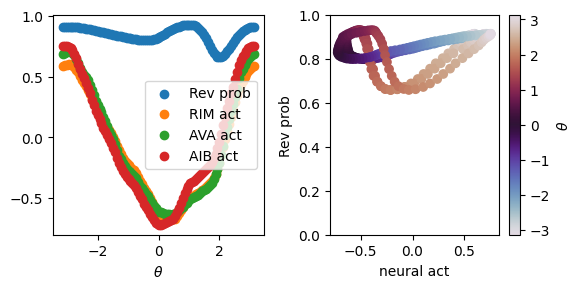

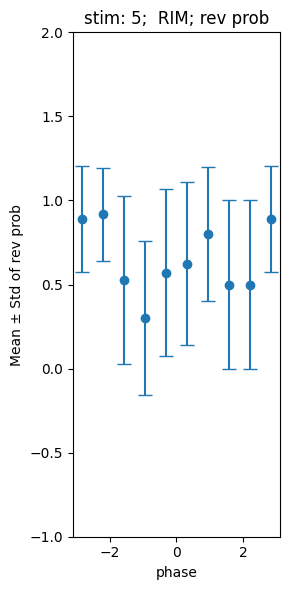

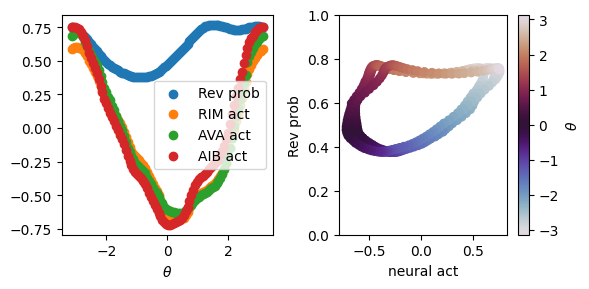

In [ ]:
def plot_binned_counts(x,y,title_supp="",  fig = None, ax = None, n_bins = 10):
    # Define bin edges
    bin_edges = np.linspace(-1*np.pi, np.pi, n_bins + 1)

    # Digitize x values to bin indices
    bin_indices = np.digitize(x, bin_edges) - 1

    # Preallocate arrays
    means = np.zeros(n_bins)
    stds = np.zeros(n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute mean and std per bin
    for i in range(n_bins):
        mask = bin_indices == i
        if np.any(mask):
            means[i] = np.mean(y[mask])
            stds[i] = np.std(y[mask])
        else:
            means[i] = np.nan
            stds[i] = np.nan

    ax.errorbar(bin_centers, means, yerr=stds, fmt='o', capsize=5)
    ax.set_xlabel('phase')
    ax.set_ylabel('Mean ± Std of rev prob')
    ax.set_ylim([-1, 2])
    ax.set_title(f'{title_supp} {neuron}; rev prob')
    # plt.show()


# Plot
fig,ax = plt.subplots(1,2,figsize=(6,6))

if neuron == "AVA":
    idxs = [[0,-1],[1],[2], [3,4]]
    idxs = [[0],[1],[2],[3],[4],[5]]
if neuron == "RIM":
    idxs = [[0,-1],[1], [2,3,4]]
    idxs = [[0],[1],[2],[3],[4],[5]]
if neuron == "AIB":
    idxs = [[0,-1],[1,2], [3,4]]
# if neuron == "AIB":
#     idxs = [[0,-1],[1], [2], [3], [4]]
#     idxs = [[0],[1],[2],[3],[4],[5]]

for i in range(len(idxs)):

    x0,x1 = np.concatenate(inferred_phases[idxs[i]]), np.concatenate(inferred_rad[idxs[i]])
    y = np.concatenate(final_behaviors[idxs[i]])
    x = np.stack((x0, x1)).T
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]

    fig1,ax1 = plt.subplots(figsize=(3,6))
    # ax1.scatter(x0[non_nan_ys], y, label = i)
    plot_binned_counts(x0,y,title_supp = f"stim: {i}; ",fig = fig1, ax = ax1, n_bins = 10)
    
    
    
    y_est = fit_and_evaluate_kernel_regression(x, y, method="kernel", bandwidths=(0.3,0.3), plot=True, kernel_type=("vonmises", "gaussian"), ax=ax[1], alpha = 0.1 + 0.2*(i%5), return_est=True)
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_ylabel("Reversal probability")
    ax[1].set_ylim(0,1)
    ax[1].set_title(neuron)
    ax[1].axvline(-2.1, color='k')
    ax[1].axvline(1.3, color='k')
    ax[1].set_xlim(-np.pi, np.pi)


    if True: # plot rev probability vs mean trace
        fig2,ax2  = plt.subplots(1,2, figsize=(6,3))
        ax2[0].scatter(np.linspace(-np.pi, np.pi, 100), y_est, label="Rev prob")

        neuron_names = ["RIM", "AVA", "AIB"]
        i = 0
        for y_est2 in y_est2s:
            ax2[0].scatter(np.linspace(-np.pi, np.pi, 100), y_est2, label=f"{neuron_names[i]} act")
            im = ax2[1].scatter(y_est2, y_est, c = np.linspace(-np.pi, np.pi, 100), cmap="twilight")
            i+=1


        ax2[0].set_xlabel(r"$\theta$")
        cb = fig.colorbar(im)
        cb.set_label(r"$\theta$")
        ax2[1].set_ylabel("Rev prob")
        ax2[1].set_xlabel(f"neural act")
        ax2[1].set_ylim(0,1)
        ax2[0].legend()
        fig2.tight_layout()


for i in range(1,len(final_behs)):


    x0,x1 = np.concatenate(worm_angles[0:5]), np.concatenate(worm_radii[0:5])
    y = np.array(final_behs[i])
    x = np.stack((x0, x1)).T
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]


    
    
    y_est = fit_and_evaluate_kernel_regression(x, y, method="kernel", bandwidths=(0.3,0.3), plot=True, kernel_type=("vonmises", "gaussian"), ax=ax[0], alpha = 0.1 + 0.2*(i%5), return_est=True)


    ax[0].set_xlabel(r"$\theta$")
    ax[0].set_ylabel("Reversal probability")
    ax[0].set_title("Simulations")
    ax[0].axvline(-2.1, color='k')
    ax[0].axvline(1.3, color='k')
    ax[0].set_ylim(0,1)


fig.tight_layout()
